<div align="center" style="border:solid 1px gray;">
    <a href="https://openalex.org/">
        <img src="../../resources/img/OpenAlex-banner.png" alt="OpenAlex banner" width="300">
    </a>
</div>

# Eine empirische Untersuchung zu Publikationsnetzwerken am Beispiel der FernUniversität in Hagen

Dieses Notebook gibt die empirischen Auswertungen für das Seminar Komplexe Netze im Wintersemester 2025/26 von Prof. Dr. Zhong Li wieder.

Ersteller: Judith Göd & Frank Wehinger

Der Code beruht teilweise auf einem [Tutorial von OpenAlex](https://github.com/ourresearch/openalex-api-tutorials/blob/main/notebooks/institutions/uw-collaborators.ipynb).



[Institutionen](https://docs.openalex.org/api-entities/institutions) in OpenAlex benutzen als Single Opject Identifier das [ROR registry](https://ror.org/), in dem sehr viele forschenden Organisationen abgedeckt sind. Hier haben wir die [ROR-ID für die FeU](https://ror.org/04tkkr536) identifiziert.

In [1]:
import sys
print(sys.executable)

/Users/frankwehinger/Documents/FU/KomplexeNetze/Daten/.venv/bin/python


In [1]:
feu_id = "https://ror.org/04tkkr536"

In [7]:
!cd /Users/frankwehinger/Documents/FU/KomplexeNetze

# Neue virtuelle Umgebung anlegen
!python3 -m venv .venv

# Aktivieren (sehr wichtig)
!source .venv/bin/activate    # auf macOS / zsh
# In der Shell steht dann vorne meist (.venv)

In [7]:
import sys

# Alle Pakete, die du in deinem Notebook nutzt
packages = [
    "pandas",
    "requests",
    "tqdm",
    "networkx",
    "matplotlib",
    "plotly",
    "nbformat",          # nötig für Plotly-Rendering im Notebook
    "country_converter", # falls du coco / CountryConverter verwendest
]

# erst pip selbst aktualisieren (optional, aber hilfreich)
!{sys.executable} -m pip install --upgrade pip

# dann alle benötigten Pakete in DIESE venv installieren
!{sys.executable} -m pip install -U {" ".join(packages)}

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/44/3c/d717024885424591d5376220b5e836c2d5293ce2011523c9de23ff7bf068/pip-25.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached charset_normalizer-3.4.4-cp312-cp312-macosx_10_13_universal2.whl.metadata (37 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
  Using cached c

In [8]:
from pathlib import Path
import os

# Basisordner für dein Projekt / deine Daten
base_dir = Path("/Users/frankwehinger/Documents/FU/KomplexeNetze/Daten")
base_dir.mkdir(parents=True, exist_ok=True)  # Falls "Daten" noch nicht existiert

print("Base dir:", base_dir)

Base dir: /Users/frankwehinger/Documents/FU/KomplexeNetze/Daten


## Daten der FeU-Publikationen beziehen

Um die Daten für unsere Studie zu erhalten, müssen wir alle Werke aus OpenAlex sammeln, die mindestens einen Autor von der FeU und mindestens einen Autor außerhalb der UW haben. Dazu gehen wir in zwei Schritten vor: Zunächst sammeln wir alle Werke mit Autoren von der FeU, dann filtern wir diese, um nur die Arbeiten mit mindestens einer weiteren Zugehörigkeit zu behalten.

Mit der im folgenden Code-Block ausgegebenen URL kann man sich die Werke im Browser anzeigen lassen, wozu man am besten eine JSON-Extension benutzt.

In [9]:
### ADD YOUR EMAIL to use the polite pool
email = "frankpaul.wehinger@gmail.com"

# specify endpoint
endpoint = 'works'

# build the 'filter' parameter
# We'll limit it to the last 10 years
filters = ",".join((
    f'institutions.ror:{feu_id}',
    'from_publication_date:2015-01-01',
    'to_publication_date:2024-12-31',
))

# put the URL together
filtered_works_url = f'https://api.openalex.org/{endpoint}?filter={filters}'
if email:
    filtered_works_url += f"&mailto={email}"
print(f'complete URL with filters:\n{filtered_works_url}')

complete URL with filters:
https://api.openalex.org/works?filter=institutions.ror:https://ror.org/04tkkr536,from_publication_date:2015-01-01,to_publication_date:2024-12-31&mailto=frankpaul.wehinger@gmail.com


Nun müssen die Daten für die weitere Auswertung für Python bereitgestellt werden. Wir holen die Ergebnisse von der API mithilfe der `requests` library.

In [10]:
import requests

In [11]:
r = requests.get(filtered_works_url)
results_page = r.json()
print(f"retrieved {len(results_page['results'])} works")

retrieved 25 works


Pro Seite werden 25 Werke gesammelt. Mithilfe des Wertes `results_page['meta']['count']` kann die Gesamtzahl an Werken ausgegeben weren:

In [12]:
print(f"Gesamtzahl an Publikationen der FeU im Untersuchungszeitraum: {results_page['meta']['count']} Veröffentlichungen")

Gesamtzahl an Publikationen der FeU im Untersuchungszeitraum: 5268 Veröffentlichungen


In [13]:
# there are 25 results per page
print(f"Anzahl der Seiten: {results_page['meta']['count'] / 25}")

Anzahl der Seiten: 210.72


### Alle Publikationsdaten herunterladen

Es gibt über 5.500 Werke (s.o.). Um diese Abzurufen verwenden wie die [Paging über die API](https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/paging). Um ggf. eine noch größere Menge an Publikation abrufen zu können, verwenden wir die Cursor-Paging-Technik.


In [14]:
cursor = '*'

select = ",".join((
    'id',
    'ids',
    'title',
    'display_name',
    'publication_year',
    'publication_date',
    'primary_location',
    'open_access',
    'authorships',
    'cited_by_count',
    'is_retracted',
    'is_paratext',
    'updated_date',
    'created_date',
))

# loop through pages
works = []
loop_index = 0
while cursor:

    # set cursor value and request page from OpenAlex
    url = f'{filtered_works_url}&select={select}&cursor={cursor}'
    page_with_results = requests.get(url).json()

    results = page_with_results['results']
    works.extend(results)

    # update cursor to meta.next_cursor
    cursor = page_with_results['meta']['next_cursor']
    loop_index += 1
    if loop_index in [5, 10, 20, 50, 100] or loop_index % 500 == 0:
        print(f'{loop_index} api requests made so far')
print(f'done. made {loop_index} api requests. collected {len(works)} works')

5 api requests made so far
10 api requests made so far
20 api requests made so far
50 api requests made so far
100 api requests made so far
done. made 212 api requests. collected 5268 works


### Rohdaten speichern

Um nicht jedes Mal die Daten neu über die API abrufen zu müssen, speichern wir sie und verwenden dazu das [`.pickle`](https://docs.python.org/3/library/pickle.html)-Datenformat.

In [ ]:
import pickle

file_path = base_dir / "feu_works_since_2015.pickle"

with open(file_path, "wb") as outf:
    pickle.dump(works, outf, protocol=pickle.HIGHEST_PROTOCOL)

print("Datei gespeichert unter:", file_path)
print("Anzahl gespeicherter Werke:", len(works))

Datei gespeichert unter: /Users/frankwehinger/Documents/FU/KomplexeNetze/Daten/feu_works_since_2015.pickle
Anzahl gespeicherter Werke: 5268


Und so kann man die Datei wieder laden:

(Das ist der Einstiegspunkt für alle folgenden Analysen, wenn die Daten berits gespeichert sind)

In [164]:
import pickle

file_path = base_dir / "feu_works_since_2015.pickle"

with open(file_path, "rb") as f:
    works = pickle.load(f)

In [16]:
''' Wenn man sich das angucken will: hier die Länge der Liste und als Beispiel
der erste Eintrag. Man sieht dort auch, wie viele unterschiedliche Attribute
vorhanden sind'''
type(works)
print(len(works))
works[0]

5268


{'id': 'https://openalex.org/W2816458595',
 'ids': {'openalex': 'https://openalex.org/W2816458595',
  'doi': 'https://doi.org/10.1007/s11757-018-0478-z',
  'mag': '2816458595'},
 'title': 'Hare Psychopathy Checklist-Revised',
 'display_name': 'Hare Psychopathy Checklist-Revised',
 'publication_year': 2018,
 'publication_date': '2018-07-05',
 'primary_location': {'id': 'doi:10.1007/s11757-018-0478-z',
  'is_oa': False,
  'landing_page_url': 'https://doi.org/10.1007/s11757-018-0478-z',
  'pdf_url': None,
  'source': {'id': 'https://openalex.org/S159458168',
   'display_name': 'Forensische Psychiatrie Psychologie Kriminologie',
   'issn_l': '1862-7072',
   'issn': ['1862-7072', '1862-7080'],
   'is_oa': False,
   'is_in_doaj': False,
   'is_core': True,
   'host_organization': 'https://openalex.org/P4310319900',
   'host_organization_name': 'Springer Science+Business Media',
   'host_organization_lineage': ['https://openalex.org/P4310319900',
    'https://openalex.org/P4310319965'],
   'h

### Mit Pandas die Daten auswertbar machen


In [165]:
import pandas as pd
data = []
for work in works:
    for authorship in work['authorships']:
        if authorship:
            author = authorship['author']
            author_id = author['id'] if author else None
            author_name = author['display_name'] if author else None
            author_position = authorship['author_position']
            for institution in authorship['institutions']:
                if institution:
                    institution_id = institution['id']
                    institution_name = institution['display_name']
                    institution_country_code = institution['country_code']
                    data.append({
                        'work_id': work['id'],
                        'work_title': work['title'],
                        'work_display_name': work['display_name'],
                        'work_publication_year': work['publication_year'],
                        'work_publication_date': work['publication_date'],
                        'author_id': author_id,
                        'author_name': author_name,
                        'author_position': author_position,
                        'institution_id': institution_id,
                        'institution_name': institution_name,
                        'institution_country_code': institution_country_code,
                    })
df = pd.DataFrame(data)

Ein Problem wird jetzt sichtbar: wenn keine offizielle Institution vorhanden ist wie bei den beiden Koautorinnen von https://openalex.org/W2816458595, wird diese Institution auch nicht in den Pandas-Dataframe übernommen. Es fallen damit einige Partner weg.

In [18]:
df.head()

,work_id,work_title,work_display_name,work_publication_year,work_publication_date,author_id,author_name,author_position,institution_id,institution_name,institution_country_code
0,https://openalex.org/W2816458595,Hare Psychopathy Checklist-Revised,Hare Psychopathy Checklist-Revised,2018,2018-07-05,https://openalex.org/A5069628734,Andreas Mokros,middle,https://openalex.org/I120691247,University of Hagen,DE
1,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5025090549,Rainer Guski,first,https://openalex.org/I904495901,Ruhr University Bochum,DE
2,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5007915419,Dirk Schreckenberg,middle,https://openalex.org/I4210129828,"Centre for Applied Psychology, Environmental a...",DE
3,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5033948437,Rudolf Schuemer,last,https://openalex.org/I120691247,University of Hagen,DE
4,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5033055029,Helena R. M. Radke,first,https://openalex.org/I98677209,University of Edinburgh,GB


Auch hier prüfen, was mit diesem De Gruyter Brill (Germany) ist. Das ist nur Frontmatter. Muss raus.

In [166]:
mask = df["institution_name"] == "De Gruyter Brill (Germany)"
df_degruyter = df[mask].copy()

# als CSV speichern (Pfad anpassen)
df_degruyter.to_csv("de_gruyter_brill_germany_works.csv", index=False)

### Filtern für externe Kooperationen

Wir sind nur an Publikationen interessiert, die mindestens einen Autor außerhalb der FeU haben. Wir kennzeichnen also jede Zeile mit dieser Information.

Zunächst werden die Funktionen definiert.

In [19]:
def outside_feu_collab(institution_ids):
    # Function that takes institution IDs (grouped by works)
    # and returns True if the work has at least one non-FeU affiliation
    if all(institution_ids == 'https://openalex.org/I120691247'):
        return False
    else:
        return True
# transform() will return a series the same length as the dataframe,
# which we can store as a column in the dataframe
df['is_outside_feu_collab'] = df.groupby('work_id')['institution_id'].transform(outside_feu_collab)

Es wird ein neuer Dataframe namens df_collab geschaffen, der nur Kombinationen aus Publikationen und Autoren enthält, die einer Kollaboration entspringen. Das macht df[].

In [20]:
df_collab = df[df['is_outside_feu_collab']].drop(columns='is_outside_feu_collab')
print(f"dataframe has {len(df_collab):,} rows, with {df_collab['work_id'].nunique():,} unique publications")

dataframe has 24,046 rows, with 2,650 unique publications


Es gibt ein Problem mit der Institution De Gruyter Brill (Germany). Hier kommen fehlerhafte Werke rein. Es handelt sich um Frontmatter und das nicht zu wenig. Dies zeigt der folgende Code.

In [21]:
print(f"Anzahl de Gruyter Brill: {df_collab[df_collab["institution_name"] == "De Gruyter Brill (Germany)"].shape[0]}")
df_degruyter_brill = df_collab[df_collab["institution_name"] == "De Gruyter Brill (Germany)"]
df_degruyter_brill.head(20)

Anzahl de Gruyter Brill: 523


,work_id,work_title,work_display_name,work_publication_year,work_publication_date,author_id,author_name,author_position,institution_id,institution_name,institution_country_code
15615,https://openalex.org/W4200251713,Frontmatter,Frontmatter,2021,2021-09-16,https://openalex.org/A5094386211,Verantwortlicher Herausgeber,first,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15617,https://openalex.org/W4200251713,Frontmatter,Frontmatter,2021,2021-09-16,https://openalex.org/A5094386212,H Vormbaum,middle,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15619,https://openalex.org/W4200251713,Frontmatter,Frontmatter,2021,2021-09-16,https://openalex.org/A5094386213,Markus Anzeigenverantwortliche,middle,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15621,https://openalex.org/W4200251713,Frontmatter,Frontmatter,2021,2021-09-16,https://openalex.org/A5094386214,Christoph Satz,middle,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15623,https://openalex.org/W4200251713,Frontmatter,Frontmatter,2021,2021-09-16,https://openalex.org/A5094386215,Fernuniversität Hagemann,middle,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15625,https://openalex.org/W4200251713,Frontmatter,Frontmatter,2021,2021-09-16,https://openalex.org/A5094386216,Hagen In,middle,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15627,https://openalex.org/W4200251713,Frontmatter,Frontmatter,2021,2021-09-16,https://openalex.org/A5094302919,Franz Druck,middle,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15629,https://openalex.org/W4200251713,Frontmatter,Frontmatter,2021,2021-09-16,https://openalex.org/A5094302920,Druck Stückle,last,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15649,https://openalex.org/W4200458524,Frontmatter,Frontmatter,2021,2021-10-01,https://openalex.org/A5001759397,Markus Kirschbaum,middle,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE
15650,https://openalex.org/W4200458524,Frontmatter,Frontmatter,2021,2021-10-01,https://openalex.org/A5094454501,Markus Anzeigenverantwortlicher,last,https://openalex.org/I4210125361,De Gruyter Brill (Germany),DE


Daher werden Zeilen mit dieser problmatischen Institution entfernt.

In [167]:
# Problematische Institution entfernen
df_collab = df_collab[df_collab["institution_name"] != "De Gruyter Brill (Germany)"].copy()
print(f"nach Entfernen von De Gruyter Brill: {len(df_collab):,} Zeilen, {df_collab['work_id'].nunique():,} Publikationen")

nach Entfernen von De Gruyter Brill: 23,523 Zeilen, 2,650 Publikationen


In [23]:
# Überprüfen, ob alles geklappt hat: Das mit dem Hare Psychopathy Checklist sollte jetzt
# draußen sein.
# Hier werden die ersten zehn Zeilen angezeigt:
df_collab.head(10)

,work_id,work_title,work_display_name,work_publication_year,work_publication_date,author_id,author_name,author_position,institution_id,institution_name,institution_country_code
1,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5025090549,Rainer Guski,first,https://openalex.org/I904495901,Ruhr University Bochum,DE
2,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5007915419,Dirk Schreckenberg,middle,https://openalex.org/I4210129828,"Centre for Applied Psychology, Environmental a...",DE
3,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5033948437,Rudolf Schuemer,last,https://openalex.org/I120691247,University of Hagen,DE
4,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5033055029,Helena R. M. Radke,first,https://openalex.org/I98677209,University of Edinburgh,GB
5,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5090905828,Maja Kutlaca,middle,https://openalex.org/I170658231,Osnabrück University,DE
6,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5090905828,Maja Kutlaca,middle,https://openalex.org/I190082696,Durham University,GB
7,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5049289763,Birte Siem,middle,https://openalex.org/I120691247,University of Hagen,DE
8,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5042007466,Stephen C. Wright,middle,https://openalex.org/I18014758,Simon Fraser University,CA
9,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5057065853,Julia C. Becker,last,https://openalex.org/I170658231,Osnabrück University,DE
10,https://openalex.org/W1130077638,A highly accurate firefly based algorithm for ...,A highly accurate firefly based algorithm for ...,2015,2015-06-26,https://openalex.org/A5103329539,Nguyen Cong Long,first,https://openalex.org/I82828225,King Mongkut's University of Technology North ...,TH


Wir möchten auch wissen, wie viele dieser Kooperationen mit Einrichtungen *außerhalb Deutschlands* und nicht nur außerhalb der FeU stattfinden. Analog zu oben wird zunächst eine entpsrechende Funktion definiert und dann der Dataframe um das entsprechende Attribut der Publikationen ergänzt.

In [168]:
def international_collab(institution_country_codes):
    # Function that takes institution country codes (grouped by works)
    # and returns True if the work has at least one non-US affiliated institution
    if all(institution_country_codes == 'DE'): # hier habe ich statt 'US' 'DE' eingegeben
        return False
    else:
        return True

df_collab['is_international_collab'] = df_collab.groupby('work_id')['institution_country_code'].transform(international_collab)
num_international_collab = df_collab[df_collab['is_international_collab']]['work_id'].nunique()
print(f"Es gibt {num_international_collab:,} Publikationen mit internationaler Kooperation.")

Es gibt 1,241 Publikationen mit internationaler Kooperation.


Es handelt sich um über 1.200 Pubkikationen mit internationalen Kooperationspartnern.

In [25]:
df_collab.head(10)

,work_id,work_title,work_display_name,work_publication_year,work_publication_date,author_id,author_name,author_position,institution_id,institution_name,institution_country_code,is_international_collab
1,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5025090549,Rainer Guski,first,https://openalex.org/I904495901,Ruhr University Bochum,DE,False
2,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5007915419,Dirk Schreckenberg,middle,https://openalex.org/I4210129828,"Centre for Applied Psychology, Environmental a...",DE,False
3,https://openalex.org/W2771938996,WHO Environmental Noise Guidelines for the Eur...,WHO Environmental Noise Guidelines for the Eur...,2017,2017-12-08,https://openalex.org/A5033948437,Rudolf Schuemer,last,https://openalex.org/I120691247,University of Hagen,DE,False
4,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5033055029,Helena R. M. Radke,first,https://openalex.org/I98677209,University of Edinburgh,GB,True
5,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5090905828,Maja Kutlaca,middle,https://openalex.org/I170658231,Osnabrück University,DE,True
6,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5090905828,Maja Kutlaca,middle,https://openalex.org/I190082696,Durham University,GB,True
7,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5049289763,Birte Siem,middle,https://openalex.org/I120691247,University of Hagen,DE,True
8,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5042007466,Stephen C. Wright,middle,https://openalex.org/I18014758,Simon Fraser University,CA,True
9,https://openalex.org/W3013215247,Beyond Allyship: Motivations for Advantaged Gr...,Beyond Allyship: Motivations for Advantaged Gr...,2020,2020-05-11,https://openalex.org/A5057065853,Julia C. Becker,last,https://openalex.org/I170658231,Osnabrück University,DE,True
10,https://openalex.org/W1130077638,A highly accurate firefly based algorithm for ...,A highly accurate firefly based algorithm for ...,2015,2015-06-26,https://openalex.org/A5103329539,Nguyen Cong Long,first,https://openalex.org/I82828225,King Mongkut's University of Technology North ...,TH,True


## Deskriptive Auswertungen


Anzahl der Publikationen, Angaben für Kapitel 4.1

### (Ko-)Publikationen über die Zeit

Im Folgenden wird [Plotly](https://plotly.com/python/) genutzt, insbesondere das [`plotly.express`](https://plotly.com/python/plotly-express/)-Modul. Die Plots sind interaktiv, wenn man sie selbst im Notebook rendert.

Zuerst kommt die Verteilung *aller* Publikationen über die Zeit.

In [26]:
import plotly.express as px
# import plotly.io as pio

In [27]:
# Nur eindeutige Publikationen (eine Zeile pro work_id)
df_papers = df_collab.drop_duplicates("work_id")

collabs_by_year = (
    df_papers[df_papers["work_publication_year"] < 2025]        # Jahr-Filter
    .groupby("work_publication_year")
    .size()
    .reset_index(name="count")                                  # Anzahl Publikationen
)

fig = px.line(collabs_by_year, x="work_publication_year", y="count",
              title="Anzahl Publikationen mit externen Insitutionen pro Jahr")
fig.show()

Anzahl aller Publikationen (Tabelle 1)

In [169]:
FeU = "https://openalex.org/I120691247"

# 0) Problematische Institution aus df entfernen
df = df[df["institution_name"] != "De Gruyter Brill (Germany)"].copy()

# 1) Alle FeU-Publikationen (einmal pro Werk, bis inkl. 2024)
df_all = (
    df[df["institution_id"] == FeU]
    .drop_duplicates("work_id")
)
df_all = df_all[df_all["work_publication_year"] <= 2024]
n_all = len(df_all)

# 2) Publikationen mit externer Beteiligung:
#    df_collab NICHT neu bilden, nur für die Zählung deduplizieren
df_collab_unique = (
    df_collab
    .drop_duplicates("work_id")
)
df_collab_unique = df_collab_unique[
    df_collab_unique["work_publication_year"] <= 2024
]
n_collab = len(df_collab_unique)

# 3) Publikationen mit internationaler Beteiligung:
#    aus df_collab_unique mit is_international_collab == True
df_international = df_collab_unique[
    df_collab_unique["is_international_collab"] == True
]
n_international = len(df_international)

# 4) Anteile berechnen
p_collab_all = n_collab / n_all if n_all > 0 else float("nan")
p_int_all = n_international / n_all if n_all > 0 else float("nan")
p_int_collab = n_international / n_collab if n_collab > 0 else float("nan")

# 5) Ausgabe
print(f"Alle Publikationen (FeU, bis 2024):              {n_all}")
print(f"Publikationen mit externer Beteiligung:          {n_collab}")
print(f"Publikationen mit internationaler Beteiligung:   {n_international}\n")

print(f"Anteil mit externer Beteiligung an allen:        {p_collab_all:.3f} ({p_collab_all*100:.1f}%)")
print(f"Anteil mit internationaler Beteiligung an allen: {p_int_all:.3f} ({p_int_all*100:.1f}%)")
print(f"Anteil internationaler an allen kooperativen:    {p_int_collab:.3f} ({p_int_collab*100:.1f}%)")

Alle Publikationen (FeU, bis 2024):              5268
Publikationen mit externer Beteiligung:          2650
Publikationen mit internationaler Beteiligung:   1241

Anteil mit externer Beteiligung an allen:        0.503 (50.3%)
Anteil mit internationaler Beteiligung an allen: 0.236 (23.6%)
Anteil internationaler an allen kooperativen:    0.468 (46.8%)


Alle Publikationen: Schaubild

In [172]:
import pandas as pd
import plotly.express as px

# Pro Jahr zählen
all_by_year = (
    df_all
    .groupby("work_publication_year")
    .size()
    .reset_index(name="alle_Publikationen")
)

collab_by_year = (
    df_collab_unique
    .groupby("work_publication_year")
    .size()
    .reset_index(name="alle_koop_Publikationen")
)

intl_by_year = (
    df_international
    .groupby("work_publication_year")
    .size()
    .reset_index(name="alle_internat_Publikationen")
)

# Zu einem DataFrame mergen (alle Jahre, die irgendwo vorkommen)
df_years = (
    all_by_year
    .merge(collab_by_year, on="work_publication_year", how="outer")
    .merge(intl_by_year, on="work_publication_year", how="outer")
    .sort_values("work_publication_year")
)

# Linienplot
fig = px.line(
    df_years,
    x="work_publication_year",
    y=["alle_Publikationen", "alle_koop_Publikationen", "alle_internat_Publikationen"],
    labels={
        "work_publication_year": "Publikationsjahr",
        "value": "Anzahl Publikationen",
        "variable": "Kategorie",
    },
    title="Publikationen der FeU nach Jahr und Kooperationsart",
)

fig.update_layout(legend_title_text="Kategorie")
fig.show()

Anzahl der Publikationen mit externer Beteiligung

In [163]:
print(len(df_collab), len(df_papers[df_papers["work_publication_year"] < 2025]))

23523 2650


Jetzt das gleiche, aber nur für die *internationalen* Publikationen

In [28]:
international_collabs_by_year = (
    df_papers[(df_papers["work_publication_year"] < 2025)
    & (df_papers["is_international_collab"] == True)]        # Jahr-Filter
    .groupby("work_publication_year")
    .size()
    .reset_index(name="count")                                  # Anzahl Publikationen
)

fig = px.line(international_collabs_by_year, x="work_publication_year", y="count",
              title="Anzahl Publikationen mit internationalen Institutionen pro Jahr")
fig.show()

Jetzt beides in einer Grafik

In [29]:
# Add a 'type' column to each DataFrame before concatenating
collabs_by_year['type'] = 'Kooperative Publikationen mit allen externen Institutionen'
international_collabs_by_year['type'] = 'Davon internationale Publikationen'

# Zusammenführen
df_plot = pd.concat([collabs_by_year, international_collabs_by_year],
                    ignore_index=True)

# Eine Grafik, zwei Linien (nach 'type' unterschieden)
fig = px.line(
    df_plot,
    x="work_publication_year",
    y="count",
    color="type",  # erzeugt zwei Linien
    title="Publikationen mit allen bzw. internationalen Partnern pro Jahr"
)

fig.show()

Next, let's plot the same data, but this time by country. We'll plot the top ten countries.

We'll use the [country_converter](https://github.com/IndEcol/country_converter) python library to get more readable names for the countries.

In [158]:
import pandas as pd
import plotly.express as px
import country_converter as coco

# 1) Pro Publikation und Land nur eine Zeile behalten
df_country = df_collab.drop_duplicates(
    subset=["work_id", "institution_country_code"]
)

# 2) Counts by year and country (Anzahl Publikationen, nicht Anzahl Autor:innen)
country_by_year = (
    df_country
    .groupby(["work_publication_year", "institution_country_code"])
    .size()
    .reset_index(name="count")
)

# 3) Ländernamen aus Codes
cc = coco.CountryConverter()
country_by_year["country"] = cc.pandas_convert(
    country_by_year["institution_country_code"], to="name_short"
)

# 4) Deutsche Institutionen rausfiltern
country_by_year = country_by_year[
    country_by_year["institution_country_code"] != "DE"
]

# 5) Top 10 Länder nach Gesamtanzahl Publikationen
top_countries = (
    country_by_year.groupby("institution_country_code")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

country_by_year_subset = country_by_year[
    country_by_year["institution_country_code"].isin(top_countries)
]

# 6) Plot
fig = px.line(
    country_by_year_subset,
    x="work_publication_year",
    y="count",
    color="country",
    title="Anzahl Publikationen mit Beteiligung des Landes pro Jahr"
)
fig.show()

### Chloropleth map

Finally, let's make a [chloropleth map](https://en.wikipedia.org/wiki/Choropleth_map), which uses color to show the number of collaborations in countries around the world.

In [31]:
import plotly.express as px
import country_converter as coco

# 1) Pro Publikation und Land nur eine Zeile
df_country = df_collab.drop_duplicates(
    subset=["work_id", "institution_country_code"]
)

# 2) Länderhäufigkeit (Anzahl Publikationen mit Beteiligung des Landes)
country_counts = df_country["institution_country_code"].value_counts()

# 3) Deutschland rausfiltern
country_counts = country_counts[country_counts.index != "DE"]

# 4) In DataFrame umwandeln
country_counts = (
    country_counts
    .rename_axis("country_code")
    .reset_index(name="num_collaborations")
)

# 5) Ländernamen & ISO3-Codes ergänzen
cc = coco.CountryConverter()
country_counts["country"] = cc.pandas_convert(
    country_counts["country_code"], to="name_short"
)
country_counts["country_code_ISO3"] = cc.pandas_convert(
    country_counts["country_code"], to="ISO3"
)

# 6) Karte zeichnen
fig = px.choropleth(
    country_counts,
    locations="country_code_ISO3",
    locationmode="ISO-3",
    color="num_collaborations",
    hover_name="country",
    title="Anzahl Publikationen mit Beteiligung des Landes"
)
fig.show()

# Netzwerkanalyse mit df_collab
Die folgenden Analysen beruhen auf Koautorenschaften. Ebenso wie bei den Analysen auf Länderebene (s. o.) werden auch hier Autoren auf Werk- und Institutionenebene aggregiert: Bei einer Publikation mit Autor A von der FeU, Autor B von der externen Insitution X und Autor C von derselben externen Insitution X, wird die Verbindung zur Institution X mit der Anzahl der beteiligten Autoren gewichtet, hier als 2.

In [32]:
import networkx as nx

Unnötige Columns entfernen:

In [33]:
cols = [
    "work_id",
    "work_publication_year",
    "institution_id",
    "institution_name",
    "institution_country_code",
    "is_international_collab",
]

df_collab_net = df_collab[cols]

In [34]:
df_collab_net.head()

,work_id,work_publication_year,institution_id,institution_name,institution_country_code,is_international_collab
1,https://openalex.org/W2771938996,2017,https://openalex.org/I904495901,Ruhr University Bochum,DE,False
2,https://openalex.org/W2771938996,2017,https://openalex.org/I4210129828,"Centre for Applied Psychology, Environmental a...",DE,False
3,https://openalex.org/W2771938996,2017,https://openalex.org/I120691247,University of Hagen,DE,False
4,https://openalex.org/W3013215247,2020,https://openalex.org/I98677209,University of Edinburgh,GB,True
5,https://openalex.org/W3013215247,2020,https://openalex.org/I170658231,Osnabrück University,DE,True


Es muss gleich gezählt werden, wie oft die FeU mit anderen Partnern gemeinsam publiziert. Zuerst müssen aber Fälle entfernt werden, bei denen Institutionen mehrfach innerhalb einer Publikation vorkommen. Dann würden nämlich die Zahlen verfälscht werden. Beispiel: Publikation mit Müller von FeU, Maier, FeU und Miller, UOxford --> das ist nur EINE Kooperation zwischen FeU und UOxford.

In [35]:
df_collab_net = df_collab_net.drop_duplicates(
    subset=["work_id", "institution_id"]
).reset_index(drop=True)

In [36]:
print(f"There are {df_collab_net['institution_id'].nunique():,} institutions that collaborate with FeU, in {df_collab_net['institution_country_code'].nunique()} countries.")

There are 1,880 institutions that collaborate with FeU, in 109 countries.


In [37]:
FeU = "https://openalex.org/I120691247"

Erzeugen der Kanten. Als Gewicht dient die Anzahl der Publikationen mit dieser Partnerinstitution

In [38]:
df_edges_weighted = (
    df_collab_net[df_collab_net["institution_id"] != FeU]
    .groupby("institution_id")
    .agg(
        weight=("work_id", "nunique"), # Anzahl gemeinsamer Publikationen
        years=("work_publication_year", lambda x: sorted(set(x))), # erzeuht set mit gem. Publikationen
        # is_international_collab=("is_international_collab", "any"),
    )
    .reset_index()
)

Erzeugen der Knoten

In [39]:
df_nodes = (
    df_collab_net[["institution_id", "institution_name", "institution_country_code"]]
    .drop_duplicates()
)

Erzeugen des Networkx-Objekts. Knoten und Kanten werden Stück für Stück hinzugefügt.

In [40]:
G = nx.Graph()
# Knoten mit Attributen
for _, row in df_nodes.iterrows():
    G.add_node(
        row["institution_id"],
        institution_name=row["institution_name"],
        institution_country_code=row["institution_country_code"],
    )

# Kanten: Ego -> Partner, mit Gewicht und aggregierten Attributen
for _, row in df_edges_weighted.iterrows():
    G.add_edge(
        FeU,
        row["institution_id"],
        weight=row["weight"],
        years=row["years"],
        # is_international_collab=row["is_international_collab"],
    )

In [41]:
import matplotlib.pyplot as plt

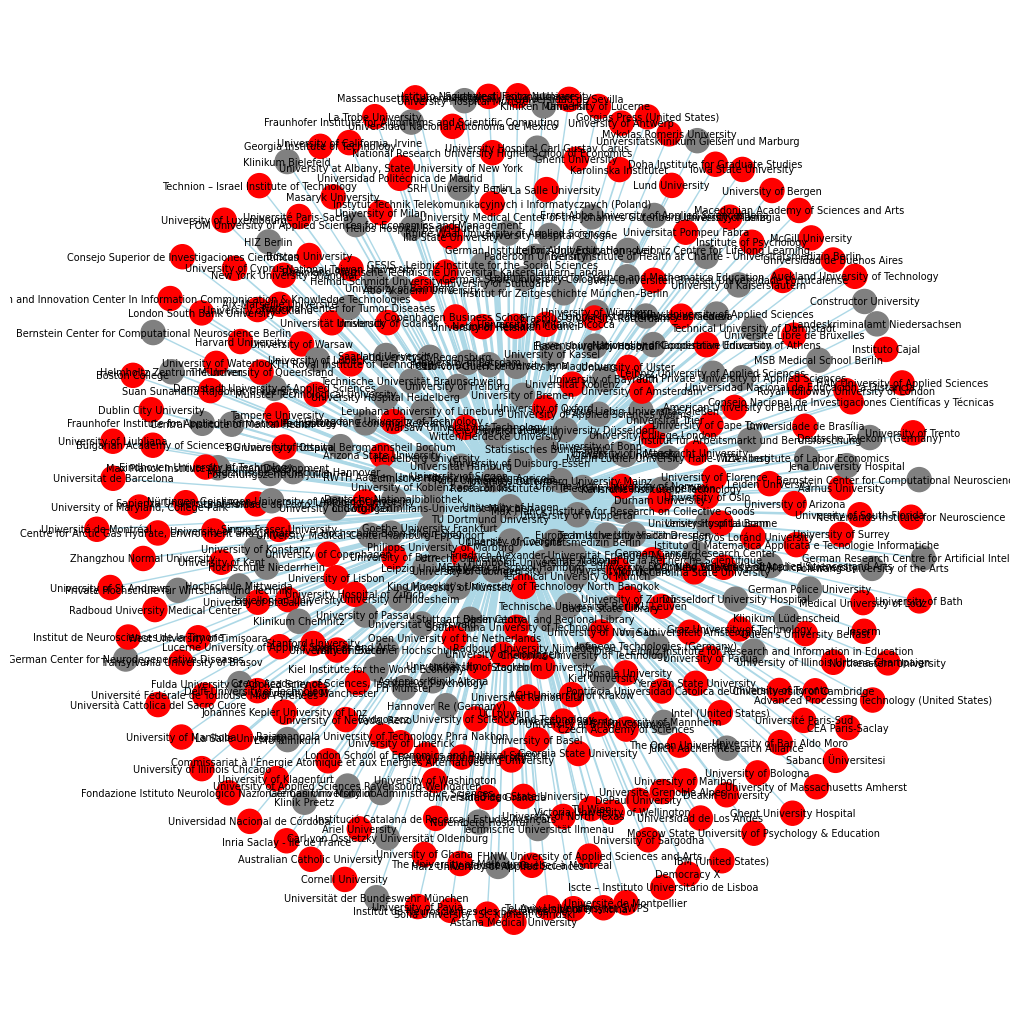

In [42]:
min_weight = 5

H = nx.Graph(
    (u, v, d)
    for u, v, d in G.edges(data=True)
    if d.get("weight", 0) >= min_weight
)

pos = nx.spring_layout(H, seed=0, weight="weight")

# Knoten-Farbe (rot = internationale Institution, grau = deutsche)
node_colors = [
    "red" if G.nodes[u].get("institution_country_code") != "DE" else "gray"
    for u in H.nodes()
]

edge_widths = [d.get("weight", 1) * 0.2 for _, _, d in H.edges(data=True)]

plt.figure(figsize=(10, 10))
nx.draw(
    H,
    pos,
    with_labels=True,
    labels={n: G.nodes[n].get("institution_name", n) for n in H.nodes()},
    node_color=node_colors,
    edge_color="lightblue",
    width=edge_widths,
    font_size=7,
)
plt.axis("off")
plt.show()

In [43]:
print("Anzahl Kanten mit Gewicht ≥ 5:", len(H.edges()))

Anzahl Kanten mit Gewicht ≥ 5: 383


## Das Gleiche für die Zeiträume 2005-2009 und 2010-2014

DataFrame für die Zeitfenster filtern

In [44]:
# 2015-2019
df_1519 = df_collab[
    df_collab["work_publication_year"].between(2015, 2019)
].copy()

# 2020-2024
df_2024 = df_collab[
    df_collab["work_publication_year"].between(2020, 2024)
].copy()

# Duplikate gleiches Werk und gleicher Autor entfernen
df_net_1519 = df_1519.drop_duplicates(subset=["work_id", "institution_id"])
df_net_2024 = df_2024.drop_duplicates(subset=["work_id", "institution_id"])

Kantengewichte berechnen

In [45]:
# 2015-2019
df_edges_1519 = (
    df_net_1519[df_net_1519["institution_id"] != FeU]
    .groupby("institution_id")
    .agg(
        weight=("work_id", "nunique"),  # Anzahl gemeinsamer Publikationen in DIESEM Zeitraum
    )
    .reset_index()
)

# 2020-2024
df_edges_2024 = (
    df_net_2024[df_net_2024["institution_id"] != FeU]
    .groupby("institution_id")
    .agg(
        weight=("work_id", "nunique"),  # Anzahl gemeinsamer Publikationen in DIESEM Zeitraum
    )
    .reset_index()
)

Knotenliste erstellen

In [46]:
# 2015-2019
df_nodes_1519 = (
    df_net_1519[["institution_id", "institution_name", "institution_country_code"]]
    .drop_duplicates()
)

# 2020-2024
df_nodes_2024 = (
    df_net_2024[["institution_id", "institution_name", "institution_country_code"]]
    .drop_duplicates()
)

Graphen erstellen

In [47]:
G_1519 = nx.Graph()

# Knoten
for _, row in df_nodes_1519.iterrows():
    G_1519.add_node(
        row["institution_id"],
        institution_name=row["institution_name"],
        institution_country_code=row["institution_country_code"],
    )

# Kanten: FeU -> Partner
for _, row in df_edges_1519.iterrows():
    G_1519.add_edge(
        FeU,
        row["institution_id"],
        weight=row["weight"],
    )

G_2024 = nx.Graph()

# Knoten
for _, row in df_nodes_2024.iterrows():
    G_2024.add_node(
        row["institution_id"],
        institution_name=row["institution_name"],
        institution_country_code=row["institution_country_code"],
    )

# Kanten: FeU -> Partner
for _, row in df_edges_2024.iterrows():
    G_2024.add_edge(
        FeU,
        row["institution_id"],
        weight=row["weight"],
    )

In [48]:
import matplotlib.pyplot as plt

Graph 2015-2019

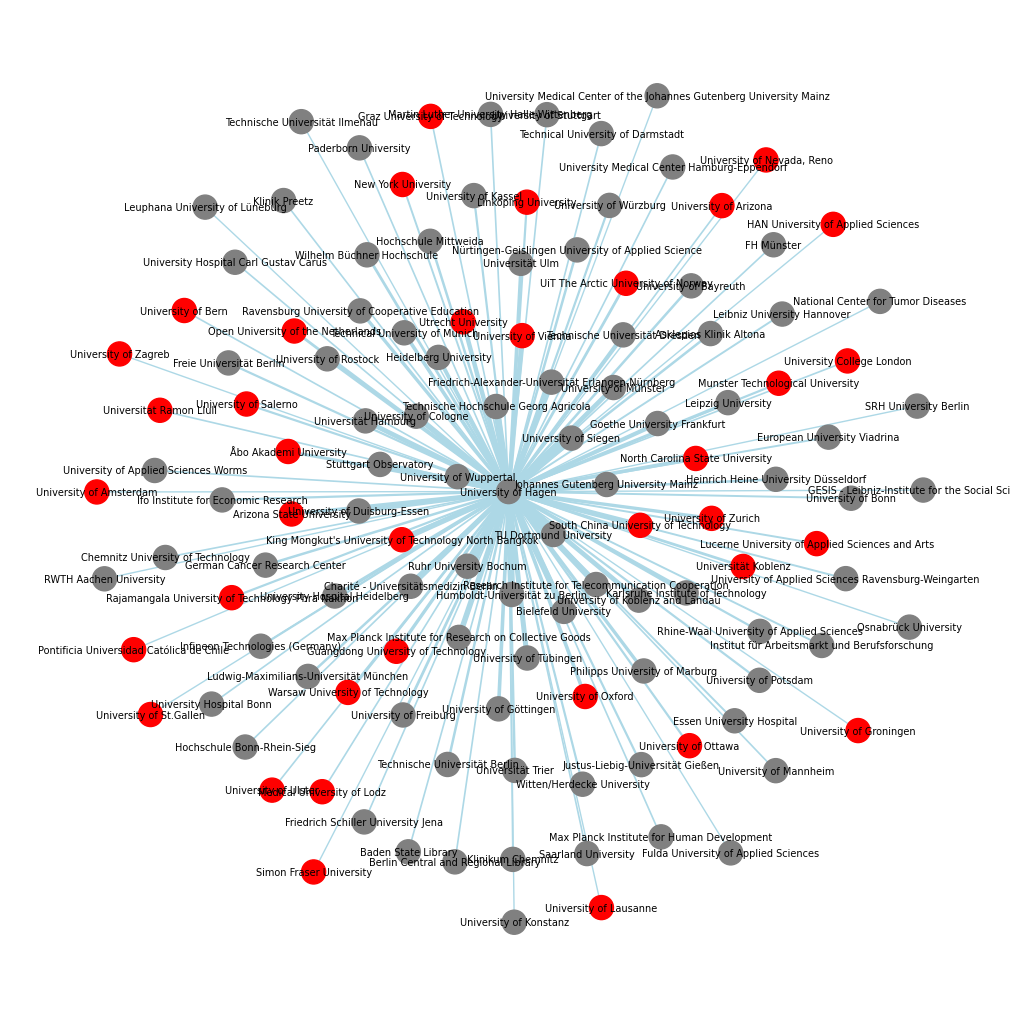

In [49]:
min_weight = 5

H_1519 = nx.Graph(
    (u, v, d)
    for u, v, d in G_1519.edges(data=True)
    if d.get("weight", 0) >= min_weight
)

pos = nx.spring_layout(H_1519, seed=0, weight="weight")

# Knoten-Farbe (rot = internationale Institution, grau = deutsche)
node_colors = [
    "red" if G_1519.nodes[u].get("institution_country_code") != "DE" else "gray"
    for u in H_1519.nodes()
]

edge_widths = [d.get("weight", 1) * 0.2 for _, _, d in H_1519.edges(data=True)]

plt.figure(figsize=(10, 10))
nx.draw(
    H_1519,
    pos,
    with_labels=True,
    labels={n: G_1519.nodes[n].get("institution_name", n) for n in H_1519.nodes()},
    node_color=node_colors,
    edge_color="lightblue",
    width=edge_widths,
    font_size=7,
)
plt.axis("off")
plt.show()

Graph 2020-2024

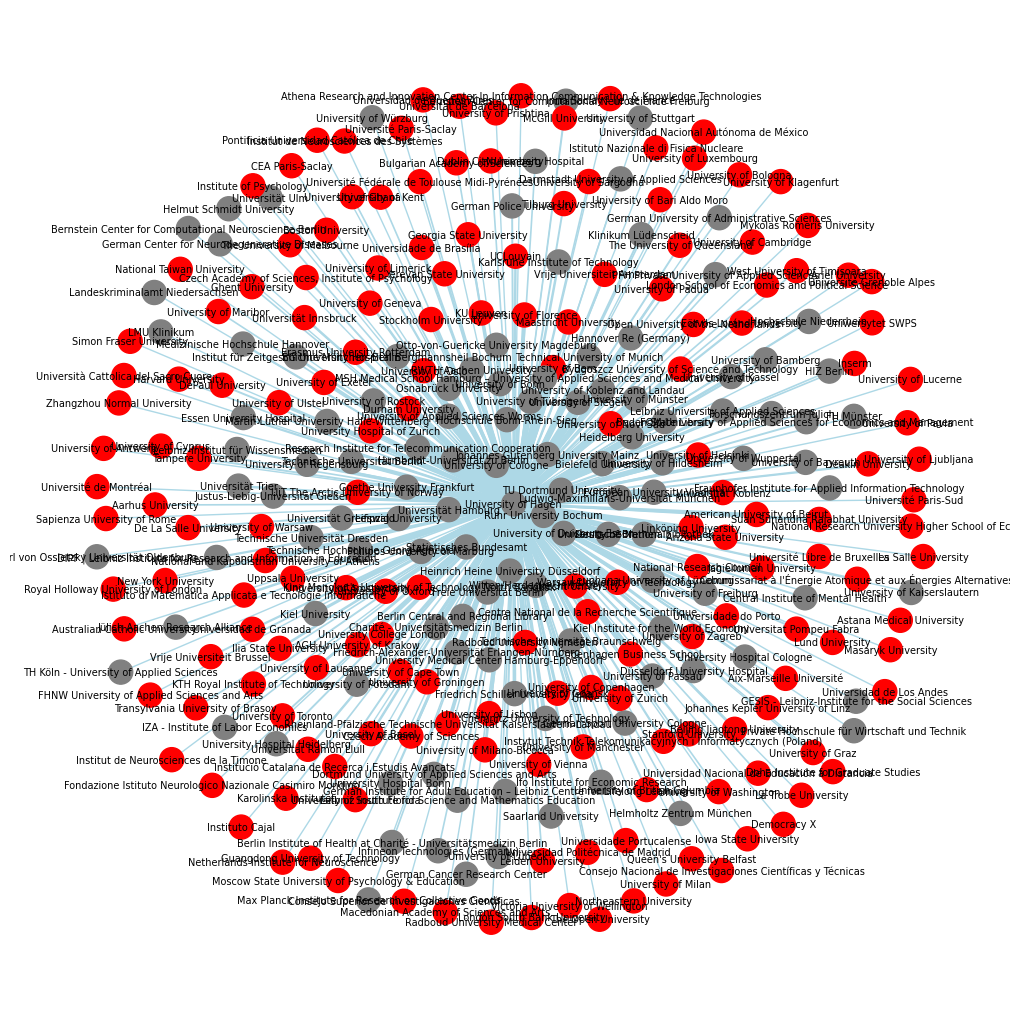

In [50]:
min_weight = 5

H_2024 = nx.Graph(
    (u, v, d)
    for u, v, d in G_2024.edges(data=True)
    if d.get("weight", 0) >= min_weight
)

pos = nx.spring_layout(H_2024, seed=0, weight="weight")

# Knoten-Farbe (rot = internationale Institution, grau = deutsche)
node_colors = [
    "red" if G_2024.nodes[u].get("institution_country_code") != "DE" else "gray"
    for u in H_2024.nodes()
]

edge_widths = [d.get("weight", 1) * 0.2 for _, _, d in H_2024.edges(data=True)]

plt.figure(figsize=(10, 10))
nx.draw(
    H_2024,
    pos,
    with_labels=True,
    labels={n: G_2024.nodes[n].get("institution_name", n) for n in H_2024.nodes()},
    node_color=node_colors,
    edge_color="lightblue",
    width=edge_widths,
    font_size=7,
)
plt.axis("off")
plt.show()

# Vorbereiten des vollen Ego-Netzwerks
Bislang wurde ein Stern-Netzwerk gebildet und dargestellt. Nun sollen die Kooperationspartner der FeU auch untereinander Beziehungen haben.  

Schritt 1: Liste der Institutionen erstellen, die im Untersuchungszeitraum mindestens 5 Publikationen mit der FeU haben.

In [79]:
import pandas as pd

FeU = "https://openalex.org/I120691247"

# 1) Zeitraum 2015–2024 filtern
df_1524 = df_collab[
    df_collab["work_publication_year"].between(2015, 2024)
].copy()

# 2) Pro Werk × Institution nur eine Zeile behalten
df_1524_net = df_1524.drop_duplicates(subset=["work_id", "institution_id"])

# 3) Anzahl gemeinsamer Publikationen FeU - jeweilige Partnerinstitutionen zählen
partner_stats = (
    df_1524_net[df_1524_net["institution_id"] != FeU]
    .groupby("institution_id")
    .agg(
        n_shared_works=("work_id", "nunique"),
        institution_name=("institution_name", "first"),
        institution_country_code=("institution_country_code", "first"),
    )
    .reset_index()
)

# --- Globale Knotenmenge: alle Partner mit >= 5 gemeinsamen Publikationen ---
all_ge5 = partner_stats[partner_stats["n_shared_works"] >= 5].copy()
all_ge5_ids = all_ge5["institution_id"].tolist()

nodes_all = [FeU] + all_ge5_ids
nodes_all_set = set(nodes_all)

print(f"Anzahl Partner mit >= 5 FeU-Publikationen: {len(all_ge5_ids)}")
print(f"Gesamtzahl Knoten (FeU + Partner >=5): {len(nodes_all_set)}")

Anzahl Partner mit >= 5 FeU-Publikationen: 383
Gesamtzahl Knoten (FeU + Partner >=5): 384


Gruppenbildung, um nicht alles auf einmal bei OpenAlex abzufragen

In [80]:
# --- Globale Knotenmenge: alle Partner mit >= 5 gemeinsamen Publikationen ---
all_ge5 = partner_stats[partner_stats["n_shared_works"] >= 5].copy()
all_ge5_ids = all_ge5["institution_id"].tolist()

nodes_all = [FeU] + all_ge5_ids
nodes_all_set = set(nodes_all)

print(f"Anzahl Partner mit >= 5 FeU-Publikationen: {len(all_ge5_ids)}")
print(f"Gesamtzahl Knoten (FeU + Partner >=5): {len(nodes_all_set)}")

# --- Gruppenbildung für die Abfragen ---

# Gruppe 1: >= 30
grp1 = partner_stats[partner_stats["n_shared_works"] >= 30]["institution_id"].tolist()

# Gruppe 2: 15–29
grp2 = partner_stats[
    (partner_stats["n_shared_works"] >= 15) &
    (partner_stats["n_shared_works"] <= 29)
]["institution_id"].tolist()

# Gruppe 3: 10–14
grp3 = partner_stats[
    (partner_stats["n_shared_works"] >= 10) &
    (partner_stats["n_shared_works"] <= 14)
]["institution_id"].tolist()

# Gruppe 4: 5–9 wird weiter unterteilt in:
#   4a: 8–9
#   4b: genau 7
#   4c: genau 6
#   4d: genau 5

grp4a_8_9 = partner_stats[
    (partner_stats["n_shared_works"] >= 8) &
    (partner_stats["n_shared_works"] <= 9)
]["institution_id"].tolist()

grp4b_7 = partner_stats[
    partner_stats["n_shared_works"] == 7
]["institution_id"].tolist()

grp4c_6 = partner_stats[
    partner_stats["n_shared_works"] == 6
]["institution_id"].tolist()

grp4d_5 = partner_stats[
    partner_stats["n_shared_works"] == 5
]["institution_id"].tolist()

print("Größe Gruppe 1 (>=30):", len(grp1))
print("Größe Gruppe 2 (15–29):", len(grp2))
print("Größe Gruppe 3 (10–14):", len(grp3))
print("Größe Gruppe 4a (8–9):", len(grp4a_8_9))
print("Größe Gruppe 4b (7):   ", len(grp4b_7))
print("Größe Gruppe 4c (6):   ", len(grp4c_6))
print("Größe Gruppe 4d (5):   ", len(grp4d_5))

Anzahl Partner mit >= 5 FeU-Publikationen: 383
Gesamtzahl Knoten (FeU + Partner >=5): 384
Größe Gruppe 1 (>=30): 28
Größe Gruppe 2 (15–29): 70
Größe Gruppe 3 (10–14): 72
Größe Gruppe 4a (8–9): 49
Größe Gruppe 4b (7):    42
Größe Gruppe 4c (6):    50
Größe Gruppe 4d (5):    72


Set-up und globale Speicherpfade

In [81]:
import requests
import time
import os
from collections import defaultdict
from tqdm.auto import tqdm
import pickle
from pathlib import Path

BASE_URL = "https://api.openalex.org/works"
MAILTO = "frankpaul.wehinger@gmail.com"

# Lokaler Datenordner
base_dir = Path("/Users/frankwehinger/Documents/FU/KomplexeNetze/Daten")
base_dir.mkdir(parents=True, exist_ok=True)

seen_works_path = base_dir / "seen_works_global.pkl"
edge_weights_path = base_dir / "edge_weights_global.pkl"
edges_csv_path = base_dir / "edges_all_2015_2024.csv"

def openalex_id_from_url(inst_url: str) -> str:
    return inst_url.rsplit("/", 1)[-1]

def fetch_works_for_institution_stream(
    inst_id_short: str,
    from_year: int = 2015,
    to_year: int = 2024,
    per_page: int = 200,
):
    """
    Generator: holt seitenweise Werke für eine Institution aus OpenAlex
    und liefert sie einzeln (yield), statt sie alle in einer Liste zu sammeln.
    """
    cursor = "*"

    while cursor:
        params = {
            "filter": (
                f"institutions.id:{inst_id_short},"
                f"from_publication_date:{from_year}-01-01,"
                f"to_publication_date:{to_year}-12-31"
            ),
            "per-page": per_page,
            "cursor": cursor,
            "mailto": MAILTO,
        }

        resp = requests.get(BASE_URL, params=params)
        resp.raise_for_status()
        data = resp.json()

        results = data.get("results", [])
        if not results:
            break

        for work in results:
            yield work

        cursor = data.get("meta", {}).get("next_cursor")
        time.sleep(0.2)  # Höflichkeit zur API

Eine Lauf-Zelle für eine Gruppe, die mehrfach verwendet werden muss

In [82]:

# erst grp1, später grp2, grp3, grp4a, etc.
this_group_ids = grp2  # <- HIER anpassen: grp1, grp2, grp3 oder grp4a-d


# 1) Globale Objekte laden oder neu anlegen
if os.path.exists(seen_works_path):
    with open(seen_works_path, "rb") as f:
        seen_works_global = pickle.load(f)
else:
    seen_works_global = set()

if os.path.exists(edge_weights_path):
    with open(edge_weights_path, "rb") as f:
        ew = pickle.load(f)
        edge_weights_global = defaultdict(int, ew)
else:
    edge_weights_global = defaultdict(int)

print(f"Schon bekannte Werke vor diesem Lauf: {len(seen_works_global)}")
print(f"Schon vorhandene Kanten vor diesem Lauf: {len(edge_weights_global)}")

# 2) Diese Gruppe in OpenAlex-Kurz-IDs umwandeln
inst_ids_short = [openalex_id_from_url(i) for i in this_group_ids]
print(f"Anzahl Institutionen in diesem Lauf: {len(inst_ids_short)}")

# 3) Stream über die Werke dieser Gruppe
for inst_id_short in tqdm(inst_ids_short, desc="Institutionen in diesem Lauf"):
    for work in fetch_works_for_institution_stream(inst_id_short):
        wid = work["id"]

        # Werk schon in irgendeinem früheren Lauf verarbeitet? → überspringen
        if wid in seen_works_global:
            continue
        seen_works_global.add(wid)

        # beteiligte Institutionen einsammeln
        insts_in_work = set()
        for auth in work.get("authorships", []):
            for inst in auth.get("institutions", []):
                inst_id_full = inst.get("id")
                if inst_id_full:
                    insts_in_work.add(inst_id_full)

        # Auf globale Knotenmenge (FeU + alle Partner >=5) beschränken
        insts_core = sorted(insts_in_work & nodes_all_set)
        if len(insts_core) < 2:
            continue

        # Alle Paare (i, j) bilden und Gewicht erhöhen
        for i_idx in range(len(insts_core)):
            for j_idx in range(i_idx + 1, len(insts_core)):
                i = insts_core[i_idx]
                j = insts_core[j_idx]
                key = (i, j)
                edge_weights_global[key] += 1

print(f"Bekannte Werke nach diesem Lauf: {len(seen_works_global)}")
print(f"Kanten nach diesem Lauf: {len(edge_weights_global)}")

# 4) Globalen Zustand auf Google Drive speichern
with open(seen_works_path, "wb") as f:
    pickle.dump(seen_works_global, f)

with open(edge_weights_path, "wb") as f:
    # defaultdict → normales dict, damit es sauber gespeichert wird
    pickle.dump(dict(edge_weights_global), f)

print("Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.")

Schon bekannte Werke vor diesem Lauf: 9822905
Schon vorhandene Kanten vor diesem Lauf: 51857
Anzahl Institutionen in diesem Lauf: 70


Institutionen in diesem Lauf:   0%|          | 0/70 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:

# erst grp1, später grp2, grp3, grp4a, etc.
this_group_ids = grp3  # <- HIER anpassen: grp1, grp2, grp3 oder grp4a-d


# 1) Globale Objekte laden oder neu anlegen
if os.path.exists(seen_works_path):
    with open(seen_works_path, "rb") as f:
        seen_works_global = pickle.load(f)
else:
    seen_works_global = set()

if os.path.exists(edge_weights_path):
    with open(edge_weights_path, "rb") as f:
        ew = pickle.load(f)
        edge_weights_global = defaultdict(int, ew)
else:
    edge_weights_global = defaultdict(int)

print(f"Schon bekannte Werke vor diesem Lauf: {len(seen_works_global)}")
print(f"Schon vorhandene Kanten vor diesem Lauf: {len(edge_weights_global)}")

# 2) Diese Gruppe in OpenAlex-Kurz-IDs umwandeln
inst_ids_short = [openalex_id_from_url(i) for i in this_group_ids]
print(f"Anzahl Institutionen in diesem Lauf: {len(inst_ids_short)}")

# 3) Stream über die Werke dieser Gruppe
for inst_id_short in tqdm(inst_ids_short, desc="Institutionen in diesem Lauf"):
    for work in fetch_works_for_institution_stream(inst_id_short):
        wid = work["id"]

        # Werk schon in irgendeinem früheren Lauf verarbeitet? → überspringen
        if wid in seen_works_global:
            continue
        seen_works_global.add(wid)

        # beteiligte Institutionen einsammeln
        insts_in_work = set()
        for auth in work.get("authorships", []):
            for inst in auth.get("institutions", []):
                inst_id_full = inst.get("id")
                if inst_id_full:
                    insts_in_work.add(inst_id_full)

        # Auf globale Knotenmenge (FeU + alle Partner >=5) beschränken
        insts_core = sorted(insts_in_work & nodes_all_set)
        if len(insts_core) < 2:
            continue

        # Alle Paare (i, j) bilden und Gewicht erhöhen
        for i_idx in range(len(insts_core)):
            for j_idx in range(i_idx + 1, len(insts_core)):
                i = insts_core[i_idx]
                j = insts_core[j_idx]
                key = (i, j)
                edge_weights_global[key] += 1

print(f"Bekannte Werke nach diesem Lauf: {len(seen_works_global)}")
print(f"Kanten nach diesem Lauf: {len(edge_weights_global)}")

# 4) Globalen Zustand auf Google Drive speichern
with open(seen_works_path, "wb") as f:
    pickle.dump(seen_works_global, f)

with open(edge_weights_path, "wb") as f:
    # defaultdict → normales dict, damit es sauber gespeichert wird
    pickle.dump(dict(edge_weights_global), f)

print("Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.")

Schon bekannte Werke vor diesem Lauf: 3636173
Schon vorhandene Kanten vor diesem Lauf: 49597
Anzahl Institutionen in diesem Lauf: 72


Institutionen in diesem Lauf: 100%|██████████| 72/72 [6:34:34<00:00, 328.81s/it]   


Bekannte Werke nach diesem Lauf: 5300574
Kanten nach diesem Lauf: 50930
Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.


In [ ]:

# erst grp1, später grp2, grp3, grp4a, etc.
this_group_ids = grp4a_8_9  # <- HIER anpassen: grp1, grp2, grp3 oder grp4a-d


# 1) Globale Objekte laden oder neu anlegen
if os.path.exists(seen_works_path):
    with open(seen_works_path, "rb") as f:
        seen_works_global = pickle.load(f)
else:
    seen_works_global = set()

if os.path.exists(edge_weights_path):
    with open(edge_weights_path, "rb") as f:
        ew = pickle.load(f)
        edge_weights_global = defaultdict(int, ew)
else:
    edge_weights_global = defaultdict(int)

print(f"Schon bekannte Werke vor diesem Lauf: {len(seen_works_global)}")
print(f"Schon vorhandene Kanten vor diesem Lauf: {len(edge_weights_global)}")

# 2) Diese Gruppe in OpenAlex-Kurz-IDs umwandeln
inst_ids_short = [openalex_id_from_url(i) for i in this_group_ids]
print(f"Anzahl Institutionen in diesem Lauf: {len(inst_ids_short)}")

# 3) Stream über die Werke dieser Gruppe
for inst_id_short in tqdm(inst_ids_short, desc="Institutionen in diesem Lauf"):
    for work in fetch_works_for_institution_stream(inst_id_short):
        wid = work["id"]

        # Werk schon in irgendeinem früheren Lauf verarbeitet? → überspringen
        if wid in seen_works_global:
            continue
        seen_works_global.add(wid)

        # beteiligte Institutionen einsammeln
        insts_in_work = set()
        for auth in work.get("authorships", []):
            for inst in auth.get("institutions", []):
                inst_id_full = inst.get("id")
                if inst_id_full:
                    insts_in_work.add(inst_id_full)

        # Auf globale Knotenmenge (FeU + alle Partner >=5) beschränken
        insts_core = sorted(insts_in_work & nodes_all_set)
        if len(insts_core) < 2:
            continue

        # Alle Paare (i, j) bilden und Gewicht erhöhen
        for i_idx in range(len(insts_core)):
            for j_idx in range(i_idx + 1, len(insts_core)):
                i = insts_core[i_idx]
                j = insts_core[j_idx]
                key = (i, j)
                edge_weights_global[key] += 1

print(f"Bekannte Werke nach diesem Lauf: {len(seen_works_global)}")
print(f"Kanten nach diesem Lauf: {len(edge_weights_global)}")

# 4) Globalen Zustand auf Google Drive speichern
with open(seen_works_path, "wb") as f:
    pickle.dump(seen_works_global, f)

with open(edge_weights_path, "wb") as f:
    # defaultdict → normales dict, damit es sauber gespeichert wird
    pickle.dump(dict(edge_weights_global), f)

print("Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.")

Schon bekannte Werke vor diesem Lauf: 5300574
Schon vorhandene Kanten vor diesem Lauf: 50930
Anzahl Institutionen in diesem Lauf: 49


Institutionen in diesem Lauf: 100%|██████████| 49/49 [3:44:14<00:00, 274.58s/it]  


Bekannte Werke nach diesem Lauf: 6267370
Kanten nach diesem Lauf: 51391
Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.


In [ ]:

# erst grp1, später grp2, grp3, grp4a, etc.
this_group_ids = grp4b_7  # <- HIER anpassen: grp1, grp2, grp3 oder grp4a-d


# 1) Globale Objekte laden oder neu anlegen
if os.path.exists(seen_works_path):
    with open(seen_works_path, "rb") as f:
        seen_works_global = pickle.load(f)
else:
    seen_works_global = set()

if os.path.exists(edge_weights_path):
    with open(edge_weights_path, "rb") as f:
        ew = pickle.load(f)
        edge_weights_global = defaultdict(int, ew)
else:
    edge_weights_global = defaultdict(int)

print(f"Schon bekannte Werke vor diesem Lauf: {len(seen_works_global)}")
print(f"Schon vorhandene Kanten vor diesem Lauf: {len(edge_weights_global)}")

# 2) Diese Gruppe in OpenAlex-Kurz-IDs umwandeln
inst_ids_short = [openalex_id_from_url(i) for i in this_group_ids]
print(f"Anzahl Institutionen in diesem Lauf: {len(inst_ids_short)}")

# 3) Stream über die Werke dieser Gruppe
for inst_id_short in tqdm(inst_ids_short, desc="Institutionen in diesem Lauf"):
    for work in fetch_works_for_institution_stream(inst_id_short):
        wid = work["id"]

        # Werk schon in irgendeinem früheren Lauf verarbeitet? → überspringen
        if wid in seen_works_global:
            continue
        seen_works_global.add(wid)

        # beteiligte Institutionen einsammeln
        insts_in_work = set()
        for auth in work.get("authorships", []):
            for inst in auth.get("institutions", []):
                inst_id_full = inst.get("id")
                if inst_id_full:
                    insts_in_work.add(inst_id_full)

        # Auf globale Knotenmenge (FeU + alle Partner >=5) beschränken
        insts_core = sorted(insts_in_work & nodes_all_set)
        if len(insts_core) < 2:
            continue

        # Alle Paare (i, j) bilden und Gewicht erhöhen
        for i_idx in range(len(insts_core)):
            for j_idx in range(i_idx + 1, len(insts_core)):
                i = insts_core[i_idx]
                j = insts_core[j_idx]
                key = (i, j)
                edge_weights_global[key] += 1

print(f"Bekannte Werke nach diesem Lauf: {len(seen_works_global)}")
print(f"Kanten nach diesem Lauf: {len(edge_weights_global)}")

# 4) Globalen Zustand auf Google Drive speichern
with open(seen_works_path, "wb") as f:
    pickle.dump(seen_works_global, f)

with open(edge_weights_path, "wb") as f:
    # defaultdict → normales dict, damit es sauber gespeichert wird
    pickle.dump(dict(edge_weights_global), f)

print("Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.")

Schon bekannte Werke vor diesem Lauf: 6267370
Schon vorhandene Kanten vor diesem Lauf: 51391
Anzahl Institutionen in diesem Lauf: 42


Institutionen in diesem Lauf: 100%|██████████| 42/42 [5:21:02<00:00, 458.64s/it]   


Bekannte Werke nach diesem Lauf: 7466474
Kanten nach diesem Lauf: 51633
Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.


In [ ]:
import json
import requests
import time

def fetch_works_for_institution_stream(
    inst_id_short: str,
    from_year: int = 2015,
    to_year: int = 2024,
    per_page: int = 200,
    max_retries: int = 5,
):
    """
    Generator: holt seitenweise Werke für eine Institution aus OpenAlex
    und liefert sie einzeln (yield).
    Bei Netzwerk-/JSON-Fehlern werden bis zu max_retries Versuche gemacht.
    """
    cursor = "*"

    while cursor:
        params = {
            "filter": (
                f"institutions.id:{inst_id_short},"
                f"from_publication_date:{from_year}-01-01,"
                f"to_publication_date:{to_year}-12-31"
            ),
            "per-page": per_page,
            "cursor": cursor,
            "mailto": MAILTO,
        }

        for attempt in range(1, max_retries + 1):
            try:
                resp = requests.get(BASE_URL, params=params, timeout=60)
                resp.raise_for_status()
                data = resp.json()  # HIER ist vorher der JSONDecodeError passiert
                break  # erfolgreich
            except (requests.exceptions.ChunkedEncodingError,
                    requests.exceptions.ConnectionError) as e:
                print(f"[Warnung] Netzwerkfehler bei {inst_id_short} (Versuch {attempt}/{max_retries}): {e}")
            except json.JSONDecodeError as e:
                print(f"[Warnung] JSON-Fehler bei {inst_id_short} (Versuch {attempt}/{max_retries}): {e}")
                print("Antwort war offenbar kein gültiges JSON (ggf. abgeschnitten oder HTML-Fehlerseite).")
            except requests.exceptions.RequestException as e:
                print(f"[Fehler] HTTP-Fehler bei {inst_id_short}: {e}")
                # bei HTTP-Fehlern brechen wir diese Institution komplett ab
                return

            if attempt == max_retries:
                print(f"[Abbruch] Gebe {inst_id_short} nach {max_retries} Fehlversuchen auf.")
                return
            # kleine Pause vor dem nächsten Versuch
            time.sleep(5)

        results = data.get("results", [])
        if not results:
            break

        for work in results:
            yield work

        cursor = data.get("meta", {}).get("next_cursor")
        time.sleep(0.2)

In [ ]:

# erst grp1, später grp2, grp3, grp4a, etc.
this_group_ids = grp4c_6  # <- HIER anpassen: grp1, grp2, grp3 oder grp4a-d


# 1) Globale Objekte laden oder neu anlegen
if os.path.exists(seen_works_path):
    with open(seen_works_path, "rb") as f:
        seen_works_global = pickle.load(f)
else:
    seen_works_global = set()

if os.path.exists(edge_weights_path):
    with open(edge_weights_path, "rb") as f:
        ew = pickle.load(f)
        edge_weights_global = defaultdict(int, ew)
else:
    edge_weights_global = defaultdict(int)

print(f"Schon bekannte Werke vor diesem Lauf: {len(seen_works_global)}")
print(f"Schon vorhandene Kanten vor diesem Lauf: {len(edge_weights_global)}")

# 2) Diese Gruppe in OpenAlex-Kurz-IDs umwandeln
inst_ids_short = [openalex_id_from_url(i) for i in this_group_ids]
print(f"Anzahl Institutionen in diesem Lauf: {len(inst_ids_short)}")

# 3) Stream über die Werke dieser Gruppe
for inst_id_short in tqdm(inst_ids_short, desc="Institutionen in diesem Lauf"):
    for work in fetch_works_for_institution_stream(inst_id_short):
        wid = work["id"]

        # Werk schon in irgendeinem früheren Lauf verarbeitet? → überspringen
        if wid in seen_works_global:
            continue
        seen_works_global.add(wid)

        # beteiligte Institutionen einsammeln
        insts_in_work = set()
        for auth in work.get("authorships", []):
            for inst in auth.get("institutions", []):
                inst_id_full = inst.get("id")
                if inst_id_full:
                    insts_in_work.add(inst_id_full)

        # Auf globale Knotenmenge (FeU + alle Partner >=5) beschränken
        insts_core = sorted(insts_in_work & nodes_all_set)
        if len(insts_core) < 2:
            continue

        # Alle Paare (i, j) bilden und Gewicht erhöhen
        for i_idx in range(len(insts_core)):
            for j_idx in range(i_idx + 1, len(insts_core)):
                i = insts_core[i_idx]
                j = insts_core[j_idx]
                key = (i, j)
                edge_weights_global[key] += 1

print(f"Bekannte Werke nach diesem Lauf: {len(seen_works_global)}")
print(f"Kanten nach diesem Lauf: {len(edge_weights_global)}")

# 4) Globalen Zustand auf Google Drive speichern
with open(seen_works_path, "wb") as f:
    pickle.dump(seen_works_global, f)

with open(edge_weights_path, "wb") as f:
    # defaultdict → normales dict, damit es sauber gespeichert wird
    pickle.dump(dict(edge_weights_global), f)

print("Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.")

Schon bekannte Werke vor diesem Lauf: 7466474
Schon vorhandene Kanten vor diesem Lauf: 51633
Anzahl Institutionen in diesem Lauf: 50


Institutionen in diesem Lauf: 100%|██████████| 50/50 [11:07:04<00:00, 800.50s/it]   


Bekannte Werke nach diesem Lauf: 8587544
Kanten nach diesem Lauf: 51805
Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.


In [ ]:

# erst grp1, später grp2, grp3, grp4a, etc.
this_group_ids = grp4d_5  # <- HIER anpassen: grp1, grp2, grp3 oder grp4a-d


# 1) Globale Objekte laden oder neu anlegen
if os.path.exists(seen_works_path):
    with open(seen_works_path, "rb") as f:
        seen_works_global = pickle.load(f)
else:
    seen_works_global = set()

if os.path.exists(edge_weights_path):
    with open(edge_weights_path, "rb") as f:
        ew = pickle.load(f)
        edge_weights_global = defaultdict(int, ew)
else:
    edge_weights_global = defaultdict(int)

print(f"Schon bekannte Werke vor diesem Lauf: {len(seen_works_global)}")
print(f"Schon vorhandene Kanten vor diesem Lauf: {len(edge_weights_global)}")

# 2) Diese Gruppe in OpenAlex-Kurz-IDs umwandeln
inst_ids_short = [openalex_id_from_url(i) for i in this_group_ids]
print(f"Anzahl Institutionen in diesem Lauf: {len(inst_ids_short)}")

# 3) Stream über die Werke dieser Gruppe
for inst_id_short in tqdm(inst_ids_short, desc="Institutionen in diesem Lauf"):
    for work in fetch_works_for_institution_stream(inst_id_short):
        wid = work["id"]

        # Werk schon in irgendeinem früheren Lauf verarbeitet? → überspringen
        if wid in seen_works_global:
            continue
        seen_works_global.add(wid)

        # beteiligte Institutionen einsammeln
        insts_in_work = set()
        for auth in work.get("authorships", []):
            for inst in auth.get("institutions", []):
                inst_id_full = inst.get("id")
                if inst_id_full:
                    insts_in_work.add(inst_id_full)

        # Auf globale Knotenmenge (FeU + alle Partner >=5) beschränken
        insts_core = sorted(insts_in_work & nodes_all_set)
        if len(insts_core) < 2:
            continue

        # Alle Paare (i, j) bilden und Gewicht erhöhen
        for i_idx in range(len(insts_core)):
            for j_idx in range(i_idx + 1, len(insts_core)):
                i = insts_core[i_idx]
                j = insts_core[j_idx]
                key = (i, j)
                edge_weights_global[key] += 1

print(f"Bekannte Werke nach diesem Lauf: {len(seen_works_global)}")
print(f"Kanten nach diesem Lauf: {len(edge_weights_global)}")

# 4) Globalen Zustand auf Google Drive speichern
with open(seen_works_path, "wb") as f:
    pickle.dump(seen_works_global, f)

with open(edge_weights_path, "wb") as f:
    # defaultdict → normales dict, damit es sauber gespeichert wird
    pickle.dump(dict(edge_weights_global), f)

print("Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.")

Schon bekannte Werke vor diesem Lauf: 8587544
Schon vorhandene Kanten vor diesem Lauf: 51805
Anzahl Institutionen in diesem Lauf: 72


Institutionen in diesem Lauf:  86%|████████▌ | 62/72 [4:32:48<33:23, 200.35s/it]   

[Fehler] HTTP-Fehler bei I46247651: 502 Server Error: Bad Gateway for url: https://api.openalex.org/works?filter=institutions.id%3AI46247651%2Cfrom_publication_date%3A2015-01-01%2Cto_publication_date%3A2024-12-31&per-page=200&cursor=Ils5Ni4wLCAzLCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzQyOTM4MTIzMjYnXSI%3D&mailto=frankpaul.wehinger%40gmail.com


Institutionen in diesem Lauf: 100%|██████████| 72/72 [6:01:30<00:00, 301.25s/it]  


Bekannte Werke nach diesem Lauf: 9822905
Kanten nach diesem Lauf: 51857
Globaler Zustand (seen_works_global, edge_weights_global) gespeichert.


## Aus den OpenAlex-Daten, die heruntergeladen wurden, ein Graph-Objekt bauen
Zuerste: Kanten-Tabelle erzeugen

Globalen edge_weights wieder laden (falls Notebook neu gestartet wurde)

In [ ]:
with open(edge_weights_path, "rb") as f:
    ew = pickle.load(f)
    edge_weights_global = defaultdict(int, ew)

In DataFrame überführen

In [86]:
df_edges_full = pd.DataFrame(
    [
        {"inst_i": i, "inst_j": j, "weight": w}
        for (i, j), w in ew.items()
    ]
)

print("Anzahl Kanten:", len(df_edges_full))
df_edges_full.head()

Anzahl Kanten: 51857


,inst_i,inst_j,weight
0,https://openalex.org/I114090438,https://openalex.org/I114112103,130
1,https://openalex.org/I114090438,https://openalex.org/I138006243,130
2,https://openalex.org/I114090438,https://openalex.org/I151201029,112
3,https://openalex.org/I114090438,https://openalex.org/I165779595,238
4,https://openalex.org/I114090438,https://openalex.org/I17937529,1490


In CSV sichern

In [87]:
edges_csv_path = base_dir / "edges_all_2015_2024.csv"
df_edges_full.to_csv(edges_csv_path, index=False)
print("Kanten-CSV gespeichert unter:", edges_csv_path)

Kanten-CSV gespeichert unter: /Users/frankwehinger/Documents/FU/KomplexeNetze/Daten/edges_all_2015_2024.csv


Knotenattribute einbauen
partner_stats hat: institution_id, institution_name, institution_country_code, n_shared_works
Daraus bedienen wir uns jetzt und erstellen den Frame df_nodes mit 

In [88]:


# Knotenliste aus den Kanten:
all_nodes = pd.unique(df_edges_full[["inst_i", "inst_j"]].values.ravel("K"))

df_nodes_full = pd.DataFrame({"institution_id": all_nodes})

# Metadaten aus partner_stats holen
df_nodes_full = df_nodes_full.merge(
    partner_stats[["institution_id", "institution_name", "institution_country_code"]],
    on="institution_id",
    how="left",
)

# Die Werte FeU separat hinzufügen, da diese noch nicht enthalten waren
# Für FeU Namen & Land setzen
df_nodes_full.loc[df_nodes_full["institution_id"] == FeU, "institution_name"] = "FernUniversität in Hagen"
df_nodes_full.loc[df_nodes_full["institution_id"] == FeU, "institution_country_code"] = "DE"

df_nodes_full.head()

,institution_id,institution_name,institution_country_code
0,https://openalex.org/I114090438,Goethe University Frankfurt,DE
1,https://openalex.org/I138006243,University of Arizona,US
2,https://openalex.org/I151201029,Consejo Nacional de Investigaciones Científica...,AR
3,https://openalex.org/I165779595,The University of Melbourne,AU
4,https://openalex.org/I17937529,German Cancer Research Center,DE


Netzwerk-Graphen bilden

In [89]:

G_full = nx.Graph()

# Knoten mit Attributen hinzufügen
for _, row in df_nodes_full.iterrows():
    G_full.add_node(
        row["institution_id"],
        institution_name=row["institution_name"],
        institution_country_code=row["institution_country_code"],
    )

# Kanten mit Gewicht hinzufügen
for _, row in df_edges_full.iterrows():
    G_full.add_edge(
        row["inst_i"],
        row["inst_j"],
        weight=row["weight"],
    )

print("Knoten im Graph:", G_full.number_of_nodes())
print("Kanten im Graph:", G_full.number_of_edges())

Knoten im Graph: 384
Kanten im Graph: 51857


## Visualisierung des vollen Netzwerks

Darstellung des Netzwerks aus Kanten mit einem Mindestgewicht von 10.

Knoten in H_full: 378
Kanten in H_full: 32351


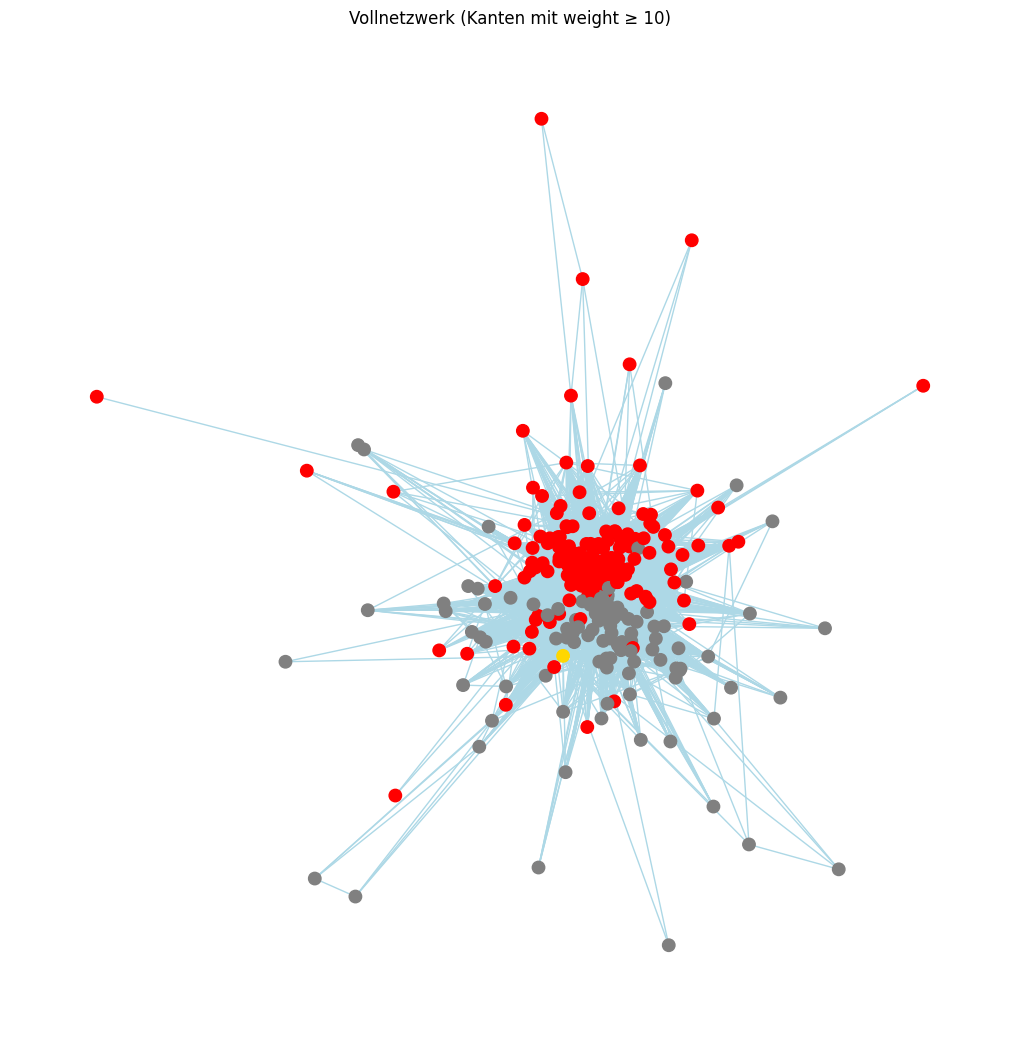

In [105]:
# Gefilterter Graph: nur Kanten mit Mindestgewicht
min_weight_full = 10  # nur Kanten mit >= 10 gemeinsamen Publikationen

H_full = nx.Graph(
    (u, v, d)
    for u, v, d in G_full.edges(data=True)
    if d.get("weight", 0) >= min_weight_full
)

print("Knoten in H_full:", H_full.number_of_nodes())
print("Kanten in H_full:", H_full.number_of_edges())

# Layout (Positionen der Knoten)
pos_full = nx.spring_layout(H_full, seed=0, weight="weight")

# Knoten-Farben:
#   - FeU: gold
#   - internationale Institutionen: rot
#   - deutsche Institutionen (ohne FeU): grau
node_colors_full = []
for u in H_full.nodes():
    if u == FeU:
        node_colors_full.append("gold")               # FeU hervorheben
    else:
        is_de = G_full.nodes[u].get("institution_country_code") == "DE"
        node_colors_full.append("gray" if is_de else "red")

# Plotten
plt.figure(figsize=(10, 10))
nx.draw(
    H_full,
    pos_full,
    with_labels=False,
    node_color=node_colors_full,
    edge_color="lightblue",
    node_size=80,
)

plt.title(f"Vollnetzwerk (Kanten mit weight ≥ {min_weight_full})")
plt.axis("off")
plt.show()

Darstellung des Netzwerks aus Kanten mit einem Mindestgewicht von 100. Hierfür ist es notwendig, nur die größte Komponente darzustellen. Es gibt nämlich zwei Knoten, die ein Paar bilden, aber die ganze Darstellung so nach unten ziehen, dass die große Komponente der anderen 335 Knoten ziemlich flach ist. 

Knoten in H_full: 359
Kanten in H_full: 17106
Knoten in größter Komponente: 359
Kanten in größter Komponente: 17106


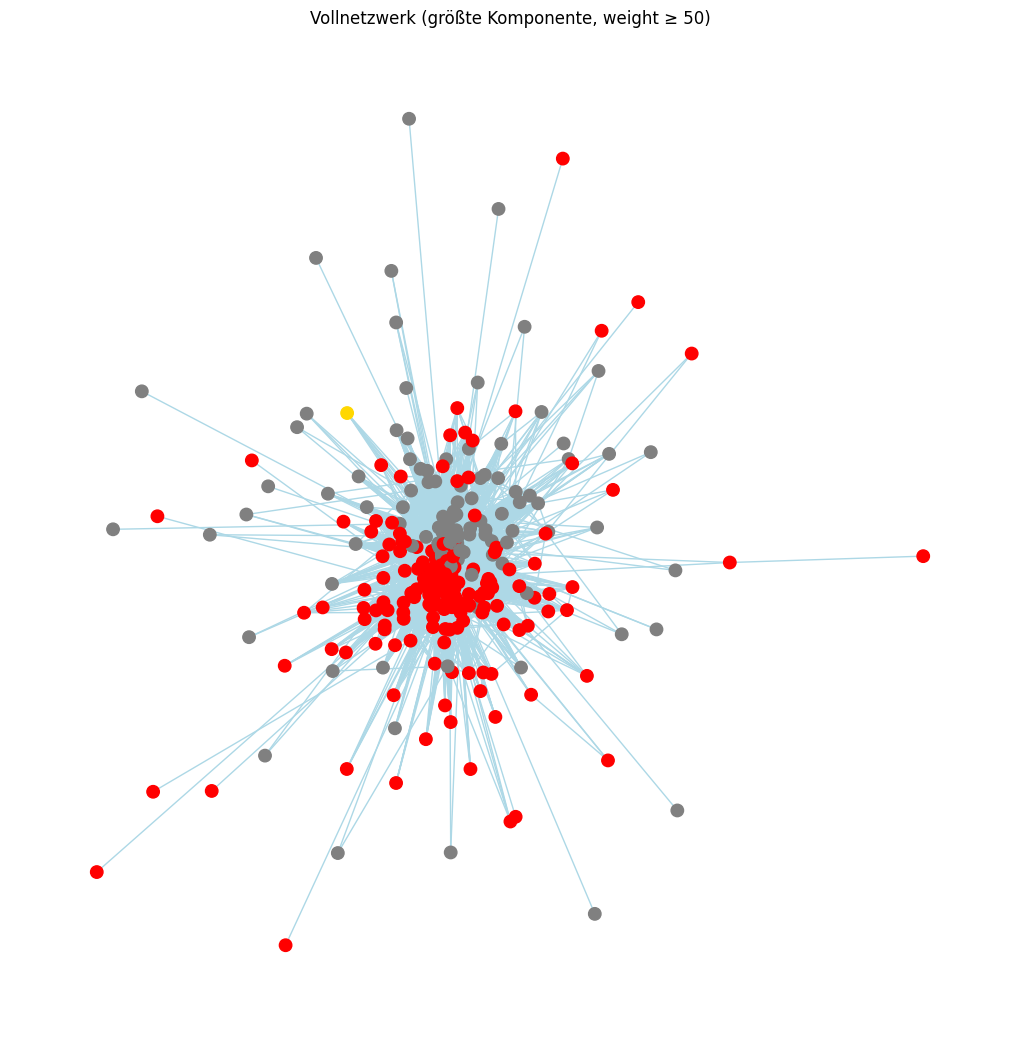

In [147]:
import matplotlib.pyplot as plt
import networkx as nx

FeU = "https://openalex.org/I120691247"  # ggf. anpassen

min_weight_full = 50  # vorher: 50

# Gefilterter Graph
H_full = nx.Graph(
    (u, v, d)
    for u, v, d in G_full.edges(data=True)
    if d.get("weight", 0) >= min_weight_full
)

print("Knoten in H_full:", H_full.number_of_nodes())
print("Kanten in H_full:", H_full.number_of_edges())

# *** Nur größte Komponente für die Visualisierung ***
components_full = list(nx.connected_components(H_full))
largest_cc_full = max(components_full, key=len)       # Menge von Knoten
H_full_main = H_full.subgraph(largest_cc_full).copy() # Teilgraph

print("Knoten in größter Komponente:", H_full_main.number_of_nodes())
print("Kanten in größter Komponente:", H_full_main.number_of_edges())

# Layout nur für diese Komponente
pos_full = nx.spring_layout(H_full_main, seed=0, weight="weight")

# Knotenfarben: FeU = gold, sonst: rot = international, grau = DE
node_colors_full = []
for u in H_full_main.nodes():
    if u == FeU:
        node_colors_full.append("gold")
    else:
        if G_full.nodes[u].get("institution_country_code") == "DE":
            node_colors_full.append("gray")
        else:
            node_colors_full.append("red")

'''edge_widths_full = [
    d.get("weight", 1) * 0.1 for _, _, d in H_full_main.edges(data=True)
]'''

plt.figure(figsize=(10, 10))
nx.draw(
    H_full_main,
    pos_full,
    with_labels=False,
    node_color=node_colors_full,
    edge_color="lightblue",
    # width=edge_widths_full,
    node_size=80,
)
plt.title(f"Vollnetzwerk (größte Komponente, weight ≥ {min_weight_full})")
plt.axis("off")
plt.show()

Knoten in H_full: 384
Kanten in H_full: 51857
Knoten in größter Komponente: 384
Kanten in größter Komponente: 51857


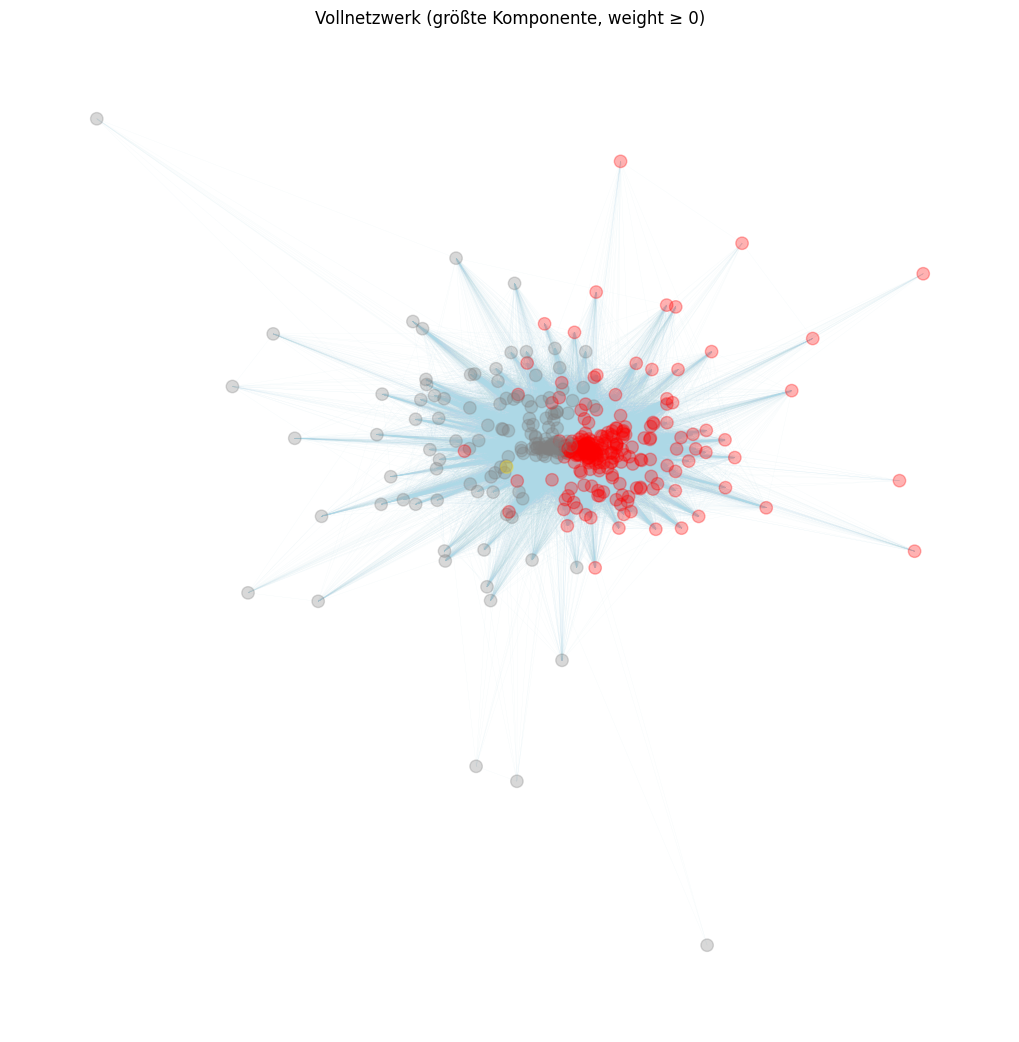

In [150]:
import matplotlib.pyplot as plt
import networkx as nx

FeU = "https://openalex.org/I120691247"  # ggf. anpassen

min_weight_full = 0  # vorher: 50

# Gefilterter Graph
H_full = nx.Graph(
    (u, v, d)
    for u, v, d in G_full.edges(data=True)
    if d.get("weight", 0) >= min_weight_full
)

print("Knoten in H_full:", H_full.number_of_nodes())
print("Kanten in H_full:", H_full.number_of_edges())

# *** Nur größte Komponente für die Visualisierung ***
components_full = list(nx.connected_components(H_full))
largest_cc_full = max(components_full, key=len)       # Menge von Knoten
H_full_main = H_full.subgraph(largest_cc_full).copy() # Teilgraph

print("Knoten in größter Komponente:", H_full_main.number_of_nodes())
print("Kanten in größter Komponente:", H_full_main.number_of_edges())

# Layout nur für diese Komponente
pos_full = nx.spring_layout(H_full_main, seed=0, weight="weight")

# Knotenfarben: FeU = gold, sonst: rot = international, grau = DE
node_colors_full = []
for u in H_full_main.nodes():
    if u == FeU:
        node_colors_full.append("gold")
    else:
        if G_full.nodes[u].get("institution_country_code") == "DE":
            node_colors_full.append("gray")
        else:
            node_colors_full.append("red")

'''edge_widths_full = [
    d.get("weight", 1) * 0.1 for _, _, d in H_full_main.edges(data=True)
]'''

plt.figure(figsize=(10, 10))
nx.draw(
    H_full_main,
    pos_full,
    with_labels=False,
    node_color=node_colors_full,
    edge_color="lightblue",
    alpha = .3,
    width = 0.1,
    # width=edge_widths_full,
    node_size=80,
)
plt.title(f"Vollnetzwerk (größte Komponente, weight ≥ {min_weight_full})")
plt.axis("off")
plt.show()

## Netzwerkanalyse

Dichte

In [113]:
n_nodes = G_full.number_of_nodes()
n_edges = G_full.number_of_edges()

density = nx.density(G_full)  # oder: 2*n_edges / (n_nodes*(n_nodes-1))

print("Knoten:", n_nodes)
print("Kanten:", n_edges)
print("Dichte des Gesamtnetzwerks:", density)

Knoten: 384
Kanten: 51857
Dichte des Gesamtnetzwerks: 0.7051920147954743


Verteilung der Kantengewichte
Es stellt sich heraus, dass es sich nicht um eine Power law-Verteilung handelt. 

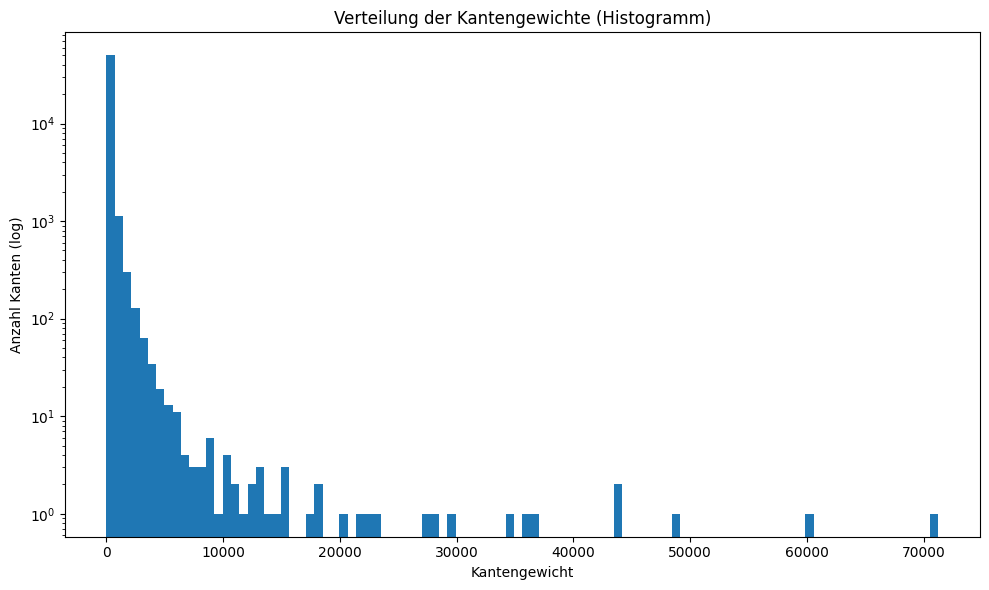

'\nplt.figure(figsize=(10, 6))\nplt.bar(weights_sorted, freqs)\n\nplt.xlabel("Kantengewicht (Anzahl gemeinsamer Publikationen)")\nplt.ylabel("Anzahl Kanten")\nplt.title("Verteilung der Kantengewichte im Vollnetzwerk")\n\n# Logarithmusskala verwenden, da man sonst nichts siehr\nplt.yscale("log")\n\nplt.tight_layout()\nplt.show()'

In [123]:
from collections import Counter
import matplotlib.pyplot as plt

# Alle Kantengewichte aus G_full entnehmen
weights = [
    d.get("weight")
    for _, _, d in G_full.edges(data=True) # d ist das Attribut-Dictionary (es besteht bei uns nur aus "weight")
] # data=True gibt die Tripel zurück; u,v,d

# Häufigkeiten zählen: weight -> count
weight_counts = Counter(weights)

# Nach Kantengewicht sortieren
weights_sorted = sorted(weight_counts.keys())
freqs = [weight_counts[w] for w in weights_sorted]

# Plotten
plt.figure(figsize=(10, 6))
plt.hist(weights, bins=100, log=True)
plt.xlabel("Kantengewicht")
plt.ylabel("Anzahl Kanten (log)")
plt.title("Verteilung der Kantengewichte (Histogramm)")
plt.tight_layout()
plt.show()
'''
plt.figure(figsize=(10, 6))
plt.bar(weights_sorted, freqs)

plt.xlabel("Kantengewicht (Anzahl gemeinsamer Publikationen)")
plt.ylabel("Anzahl Kanten")
plt.title("Verteilung der Kantengewichte im Vollnetzwerk")

# Logarithmusskala verwenden, da man sonst nichts siehr
plt.yscale("log")

plt.tight_layout()
plt.show()'''

Power-law-Verteilung prüfen. Es zeigt sich dabei, dass das NW von einem skalenfreien NW weit entfernt ist. 

Anzahl Knoten: 384
Min-Degree: 3
Max-Degree: 383
Beispiel (erste 10):
Degree 3: 1 Knoten
Degree 9: 1 Knoten
Degree 10: 1 Knoten
Degree 11: 1 Knoten
Degree 13: 1 Knoten
Degree 19: 1 Knoten
Degree 20: 1 Knoten
Degree 26: 1 Knoten
Degree 27: 1 Knoten
Degree 30: 1 Knoten


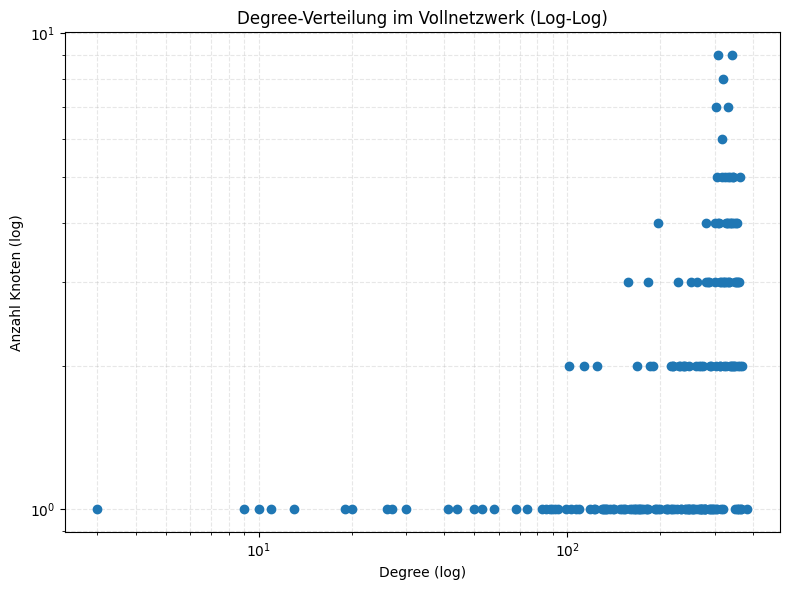

In [124]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Degree aller Knoten (ungewichtet)
degree_seq = [deg for _, deg in G_full.degree()]

print("Anzahl Knoten:", len(degree_seq))
print("Min-Degree:", min(degree_seq))
print("Max-Degree:", max(degree_seq))

# Häufigkeiten: degree -> count
deg_counts = Counter(degree_seq)

# In zwei sortierte Listen zerlegen
degrees = sorted(deg_counts.keys())
counts = [deg_counts[d] for d in degrees]

print("Beispiel (erste 10):")
for d, c in list(zip(degrees, counts))[:10]:
    print(f"Degree {d}: {c} Knoten")

# Log-Log-Plot der Degree-Verteilung
plt.figure(figsize=(8, 6))

plt.loglog(degrees, counts, marker="o", linestyle="none")  # Punkte im Log-Log

plt.xlabel("Degree (log)")
plt.ylabel("Anzahl Knoten (log)")
plt.title("Degree-Verteilung im Vollnetzwerk (Log-Log)")

plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

Knotengrad der größten Komponente bei Threshold 50, s. o., und der FeU

In [ ]:
# Durchschnittlicher Knotengrad im (ungewichteten) Netzwerk H_full_main
n_nodes = H_full_main.number_of_nodes() # H_full_main ist der Graph mit Threshhold 50
n_edges = H_full_main.number_of_edges()

avg_degree = 2 * n_edges / n_nodes   # Formel für ungerichtete Graphen
print("Durchschnittlicher Knotengrad:", avg_degree)

# Knotengrad der FeU in diesem Netzwerk
if FeU in H_full_main:
    deg_feu = H_full_main.degree(FeU)
    print("Knotengrad FeU:", deg_feu)
else:
    print("FeU ist in H_full_main nicht enthalten.")

Durchschnittlicher Knotengrad: 95.29805013927577
Knotengrad FeU: 7


In [122]:
max_weight = max(weights)
print("Maximales Kantengewicht in G_full:", max_weight)

Maximales Kantengewicht in G_full: 71264


Degree (ungewichtet und gewichtet)

In [126]:
# ungewichteter Degree
deg = dict(G_full.degree())
avg_deg = 2 * G_full.number_of_edges() / G_full.number_of_nodes()

print("Durchschnittlicher Degree:", avg_deg)
print("Degree FeU:", deg.get(FeU))

# gewichteter Degree (Strength)
strength = dict(G_full.degree(weight="weight"))
avg_strength = sum(strength.values()) / G_full.number_of_nodes()

print("Durchschnittliche Strength:", avg_strength)
print("Strength FeU:", strength.get(FeU))

Durchschnittlicher Degree: 270.0885416666667
Degree FeU: 383
Durchschnittliche Strength: 35457.765625
Strength FeU: 4873


Betweenness centrality

In [128]:
# Kantenlängen aus Gewichten ableiten
for u, v, d in G_full.edges(data=True):
    d["length"] = 1.0 / d["weight"]


betw = nx.betweenness_centrality(G_full, weight="length", normalized=True)

print("Betweenness FeU:", betw.get(FeU))

Betweenness FeU: 0.010457534209123343


Clustering

In [127]:
# ungewichtetes Clustering
clust_all = nx.clustering(G_full)
print("Durchschnittliches Clustering:", sum(clust_all.values()) / len(clust_all))
print("Clustering FeU:", clust_all.get(FeU))

# optional: gewichtetes Clustering
clust_w = nx.clustering(G_full, weight="weight")
print("Gewichtetes Clustering FeU:", clust_w.get(FeU))

Durchschnittliches Clustering: 0.8699925818861111
Clustering FeU: 0.7036485174907385
Gewichtetes Clustering FeU: 0.00017630623536562945


Test auf Power-law-Verteilung von G_full (Skalenfreiheit des Netzwerks)

In [ ]:
import numpy as np
import powerlaw 

# Ungewichteter Degree aller Knoten in G_full
degrees = np.array([deg for _, deg in G_full.degree()])

print("Anzahl Knoten:", len(degrees))
print("Min Degree:", degrees.min(), "Max Degree:", degrees.max()) 

# powerlaw fitten
 # vorher: pip install powerlaw

fit = powerlaw.Fit(degrees, discrete=True)

alpha = fit.power_law.alpha # alpha = 2 oder 3 --> Hinweis auf power law
xmin = fit.power_law.xmin # ab wo power law-artige Verteilung

print("Geschätzter Exponent alpha:", alpha)
print("Geschätztes xmin:", xmin)


Anzahl Knoten: 384
Min Degree: 3 Max Degree: 383
Calculating best minimal value for power law fit
Geschätzter Exponent alpha: 6.397745650073433
Geschätztes xmin: 269.0


Visuelle Inspektion

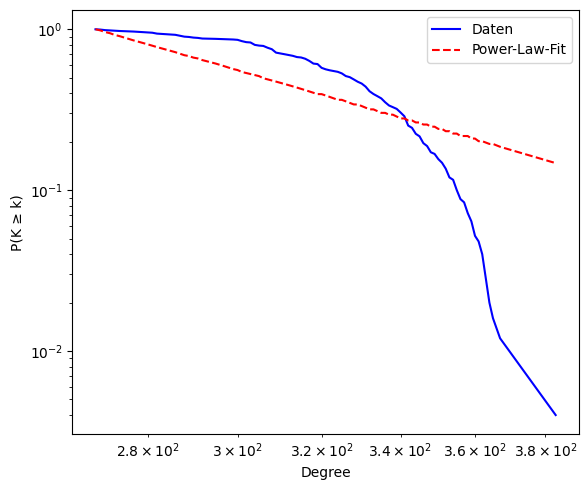

In [135]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))

# Empirische Daten
fit.plot_ccdf(color="b", label="Daten", ax=ax)

# Power-Law-Fit auf derselben Achse
fit.power_law.plot_ccdf(color="r", linestyle="--",
                        label="Power-Law-Fit", ax=ax)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Degree")
ax.set_ylabel("P(K ≥ k)")
ax.legend()
fig.tight_layout()
plt.show()

Vergleich mit Alternative

In [134]:
R_ln, p_ln = fit.distribution_compare("power_law", "lognormal")
print("Power-Law vs. Lognormal:  R =", R_ln, "p =", p_ln)

R_exp, p_exp = fit.distribution_compare("power_law", "exponential")
print("Power-Law vs. Exponential: R =", R_exp, "p =", p_exp)

Power-Law vs. Lognormal:  R = -122.26009816619221 p = 1.2013101377481051e-21
Power-Law vs. Exponential: R = -18.15146971122831 p = 8.661248118797662e-102


Jetzt das Gleiche mit den gewichteten Degrees, sprich den über die Knoten summierten Kantengewichten

Anzahl Knoten: 384
Min Strength: 13 Max Strength: 552727
Calculating best minimal value for power law fit
Strength: geschätzter Exponent alpha: 3.2959196578373984
Strength: geschätztes xmin: 75254.0


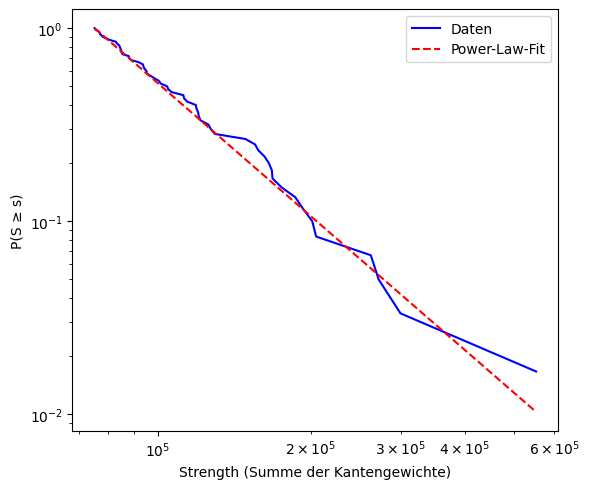

In [136]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt


# Strength = Summe der Kantengewichte pro Knoten
# (also gewichteter Degree)
strengths = np.array([s for _, s in G_full.degree(weight="weight")])

print("Anzahl Knoten:", len(strengths))
print("Min Strength:", strengths.min(), "Max Strength:", strengths.max())

# Power-Law auf die Strength-Verteilung fitten
fit_strength = powerlaw.Fit(strengths, discrete=True)

alpha_s = fit_strength.power_law.alpha
xmin_s  = fit_strength.power_law.xmin

print("Strength: geschätzter Exponent alpha:", alpha_s)
print("Strength: geschätztes xmin:", xmin_s)

# CCDF darstellen
fig, ax = plt.subplots(figsize=(6, 5))

# empirische CCDF der Strengths
fit_strength.plot_ccdf(color="b", label="Daten", ax=ax)

# theoretischer Power-Law-Fit
fit_strength.power_law.plot_ccdf(
    color="r", linestyle="--", label="Power-Law-Fit", ax=ax
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Strength (Summe der Kantengewichte)")
ax.set_ylabel("P(S ≥ s)")
ax.legend()
fig.tight_layout()
plt.show()

Jetzt soll der Wert xmin = 75254 in der Verteilung der Knotenstrengths gezeigt werden, damit man sieht, ab wann man von einer Poer-law-Verteilung sprechen kann. 

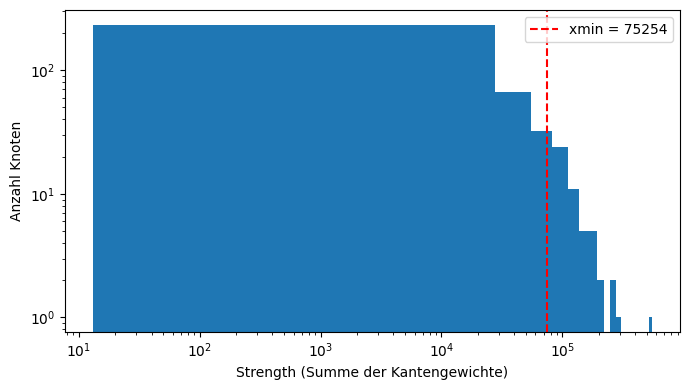

In [141]:
import matplotlib.pyplot as plt
import numpy as np

strengths = np.array([s for _, s in G_full.degree(weight="weight")]) # list comprehension über alle Knoten
xmin_s = 75254  # dein geschätztes xmin

plt.figure(figsize=(7,4))
plt.hist(strengths, bins=20)  # Anzahl Bins nach Geschmack
plt.xscale("log")
plt.yscale("log")  # optional: auskommentieren, wenn du linear auf y willst

plt.axvline(x=xmin_s, color="red", linestyle="--", label=f"xmin = {xmin_s}")
plt.xlabel("Strength (Summe der Kantengewichte)")
plt.ylabel("Anzahl Knoten")
plt.legend()
plt.tight_layout()
plt.show()

Prüfung auf exponentielle Verteilung vs. power-law-Verteilung

In [144]:
R, p = fit.distribution_compare('power_law', 'exponential')
print("R =", R, "p =", p)

R, p = fit_strength.distribution_compare('power_law', 'exponential')
print("R =", R, "p =", p)

R = -18.15146971122831 p = 8.661248118797662e-102
R = 2.927608732253436 p = 0.42061106760021594


Small-Worl-Eigenschaft untersuchen ahand der S-Metrik von Humphries und Gurney (2008)

In [ ]:
import networkx as nx
import numpy as np
import random

# Ungerichtete Version von G_full (Gewichte werden für Small-World hier ignoriert)
G_undirected = nx.Graph(G_full)

print("Knoten (G_full):", G_undirected.number_of_nodes())
print("Kanten (G_full):", G_undirected.number_of_edges())

# Clustering C und mittlere Pfadlänge L des echten Netzwerks
C = nx.average_clustering(G_undirected)
L = nx.average_shortest_path_length(G_undirected)
print(f"Originalnetz: C = {C:.4f}, L = {L:.4f}")

n = G_undirected.number_of_nodes()
m = G_undirected.number_of_edges()

# Zufallsgraphen G(n, m) zum Vergleich
n_random = 20
C_rand_list = []
L_rand_list = []

rng = np.random.default_rng(0)
random.seed(0)

for i in range(n_random):
    seed_i = int(rng.integers(0, 1_000_000))
    G_rand = nx.gnm_random_graph(n, m, seed=seed_i)

    # Falls der Zufallsgraph nicht zusammenhängend ist, auf größte Komponente beschränken
    if not nx.is_connected(G_rand):
        gc_nodes_rand = max(nx.connected_components(G_rand), key=len)
        G_rand = G_rand.subgraph(gc_nodes_rand).copy()

    C_r = nx.average_clustering(G_rand)
    L_r = nx.average_shortest_path_length(G_rand)

    C_rand_list.append(C_r)
    L_rand_list.append(L_r)

C_rand = np.mean(C_rand_list)
L_rand = np.mean(L_rand_list)

print(f"Randomgraph-Mittelwerte: C_rand = {C_rand:.4f}, L_rand = {L_rand:.4f}")

# Small-World-Index
sigma = (C / C_rand) / (L / L_rand)
print(f"Small-World-Index sigma = {sigma:.3f}")

Knoten (größte Komponente): 384
Kanten  (größte Komponente): 51857
Originalnetz: C = 0.8700, L = 1.2948
Randomgraph-Mittelwerte: C_rand = 0.7052, L_rand = 1.2948
Small-World-Index sigma = 1.234


Nun sollen die Gewichte berücksichtigt werden. 
Wir setzen das unterste Terzil der Kantengewichte gleich null, d. h. wir werfen das unterste p-Quantil mit p=1⁄3 der Kanten weg. Wir nehmen also vereinfachend an, dass die Kooperationen im ersten Terzil nicht Ausdruck einer starken Zusammenarbeit sind und daher vernachlässigt werden können

In [155]:
import networkx as nx
import numpy as np
import random

# ---------------------------------------------------------
# Unterstes Terzil der Kantengewichte bestimmen
# ---------------------------------------------------------
# Alle Gewichte aus G_full einsammeln
all_weights = [
    d.get("weight", 1)
    for _, _, d in G_full.edges(data=True)
]

q33 = np.quantile(all_weights, 1/3)  # 33%-Quantil
print(f"33%-Quantil der Kantengewichte: {q33:.2f}")

# ---------------------------------------------------------
# Gefiltertes ungewichtetes Netzwerk: Kanten mit weight < q33 werden entfernt
# ---------------------------------------------------------

# Neue Kantenliste: nur Kanten ab dem 33%-Quantil
filtered_edges = [
    (u, v, d)
    for u, v, d in G_full.edges(data=True)
    if d.get("weight", 1) >= q33
]

# Graph aufbauen:
# - alle Knoten aus G_full übernehmen (inkl. Attribute)
# - nur gefilterte Kanten übernehmen
G_filtered = nx.Graph()
G_filtered.add_nodes_from(G_full.nodes(data=True))
G_filtered.add_edges_from(filtered_edges)

print("Knoten (G_filtered):", G_filtered.number_of_nodes())
print("Kanten (G_filtered):", G_filtered.number_of_edges())

# Falls das Filtern das Netzwerk zerrissen hat,
# ist average_shortest_path_length nicht mehr auf dem ganzen Graphen definiert.
# Deshalb berücksichtigen wir für die Small-World-Analyse die größte zusammenhängende Komponente:
if not nx.is_connected(G_filtered):
    components = list(nx.connected_components(G_filtered))
    largest_cc_nodes = max(components, key=len)
    G_sw = G_filtered.subgraph(largest_cc_nodes).copy()
    print("ACHTUNG: G_filtered ist nicht zusammenhängend.")
    print("Analysiere nur die größte Komponente.")
else:
    G_sw = G_filtered

print("Knoten (für SW-Analyse):", G_sw.number_of_nodes())
print("Kanten (für SW-Analyse):", G_sw.number_of_edges())

# ---------------------------------------------------------
# Clustering C und mittlere Pfadlänge L im gefilterten echten Netzwerk
#    (ungewichtet, wie im Originalcode)
# ---------------------------------------------------------
C = nx.average_clustering(G_sw)
L = nx.average_shortest_path_length(G_sw)
print(f"Gefiltertes Netzwerk: C = {C:.4f}, L = {L:.4f}")

n = G_sw.number_of_nodes()
m = G_sw.number_of_edges()

# ---------------------------------------------------------
# Zufallsgraphen G(n, m) zum Vergleich
# ---------------------------------------------------------
n_random = 20
C_rand_list = []
L_rand_list = []

rng = np.random.default_rng(0)
random.seed(0)

for i in range(n_random):
    seed_i = int(rng.integers(0, 1_000_000))
    G_rand = nx.gnm_random_graph(n, m, seed=seed_i)

    # sicherstellen, dass der Randomgraph zusammenhängend ist
    if not nx.is_connected(G_rand):
        gc_nodes_rand = max(nx.connected_components(G_rand), key=len)
        G_rand = G_rand.subgraph(gc_nodes_rand).copy()

    C_r = nx.average_clustering(G_rand)
    L_r = nx.average_shortest_path_length(G_rand)

    C_rand_list.append(C_r)
    L_rand_list.append(L_r)

C_rand = np.mean(C_rand_list)
L_rand = np.mean(L_rand_list)

print(f"Randomgraph-Mittelwerte: C_rand = {C_rand:.4f}, L_rand = {L_rand:.4f}")

# ---------------------------------------------------------
# Small-World-Index
# ---------------------------------------------------------
sigma = (C / C_rand) / (L / L_rand)
print(f"Small-World-Index (gefiltert, unterstes Terzil entfernt) sigma = {sigma:.3f}")

33%-Quantil der Kantengewichte: 7.00
Knoten (G_filtered): 384
Kanten (G_filtered): 35785
ACHTUNG: G_filtered ist nicht zusammenhängend.
Analysiere nur die größte Komponente.
Knoten (für SW-Analyse): 381
Kanten (für SW-Analyse): 35785
Gefiltertes Netzwerk: C = 0.8351, L = 1.5197
Randomgraph-Mittelwerte: C_rand = 0.4944, L_rand = 1.5057
Small-World-Index (gefiltert, unterstes Terzil entfernt) sigma = 1.674


Jetzt das Ganze für eine Serie

In [156]:
import networkx as nx
import numpy as np
import random
import pandas as pd

# ---------------------------------------------------------
# Alle Kantengewichte aus G_full holen
# ---------------------------------------------------------
all_weights = [
    d.get("weight", 1)
    for _, _, d in G_full.edges(data=True)
]

print(f"Anzahl Kanten in G_full: {len(all_weights)}")
print(f"Min weight: {min(all_weights)}, Max weight: {max(all_weights)}")

# Welche oberen Anteile der Kanten (nach Gewicht) wollen wir behalten?
keep_fracs = [0.9, 0.8, 0.7, 0.6, 0.5]

# Ergebnisse sammeln
results = []

for keep in keep_fracs:
    drop = 1 - keep  # zu entfernender Anteil (unterstes drop-Quantil)
    q = np.quantile(all_weights, drop)
    print("\n" + "="*60)
    print(f"Behalte oberste {int(keep*100)}% der Kanten (Gewicht >= {q:.2f})")

    # ---------------------------------------------------------
    # Gefiltertes ungewichtetes Netzwerk erzeugen
    # ---------------------------------------------------------
    filtered_edges = [
        (u, v, d)
        for u, v, d in G_full.edges(data=True)
        if d.get("weight", 1) >= q
    ]

    G_filtered = nx.Graph()
    G_filtered.add_nodes_from(G_full.nodes(data=True))
    G_filtered.add_edges_from(filtered_edges)

    print("Knoten (G_filtered):", G_filtered.number_of_nodes())
    print("Kanten (G_filtered):", G_filtered.number_of_edges())

    # Für die Small-World-Analyse größte zusammenhängende Komponente nehmen,
    # falls der Graph nicht zusammenhängend ist
    if not nx.is_connected(G_filtered):
        components = list(nx.connected_components(G_filtered))
        largest_cc_nodes = max(components, key=len)
        G_sw = G_filtered.subgraph(largest_cc_nodes).copy()
        print("G_filtered ist nicht zusammenhängend – analysiere größte Komponente.")
    else:
        G_sw = G_filtered

    print("Knoten (für SW-Analyse):", G_sw.number_of_nodes())
    print("Kanten (für SW-Analyse):", G_sw.number_of_edges())

    # ---------------------------------------------------------
    # Clustering C und mittlere Pfadlänge L im gefilterten Netzwerk
    # ---------------------------------------------------------
    C = nx.average_clustering(G_sw)
    L = nx.average_shortest_path_length(G_sw)
    print(f"Gefiltertes Netzwerk: C = {C:.4f}, L = {L:.4f}")

    n = G_sw.number_of_nodes()
    m = G_sw.number_of_edges()

    # ---------------------------------------------------------
    # Zufallsgraphen G(n, m) zum Vergleich
    # ---------------------------------------------------------
    n_random = 20
    C_rand_list = []
    L_rand_list = []

    rng = np.random.default_rng(0)
    random.seed(0)

    for i in range(n_random):
        seed_i = int(rng.integers(0, 1_000_000))
        G_rand = nx.gnm_random_graph(n, m, seed=seed_i)

        # sicherstellen, dass der Randomgraph zusammenhängend ist
        if not nx.is_connected(G_rand):
            gc_nodes_rand = max(nx.connected_components(G_rand), key=len)
            G_rand = G_rand.subgraph(gc_nodes_rand).copy()

        C_r = nx.average_clustering(G_rand)
        L_r = nx.average_shortest_path_length(G_rand)

        C_rand_list.append(C_r)
        L_rand_list.append(L_r)

    C_rand = np.mean(C_rand_list)
    L_rand = np.mean(L_rand_list)

    print(f"Randomgraph-Mittelwerte: C_rand = {C_rand:.4f}, L_rand = {L_rand:.4f}")

    # ---------------------------------------------------------
    # Small-World-Index
    # ---------------------------------------------------------
    sigma = (C / C_rand) / (L / L_rand)
    print(f"Small-World-Index (keep {int(keep*100)}%) sigma = {sigma:.3f}")

    results.append({
        "keep_frac": keep,
        "threshold": q,
        "C": C,
        "L": L,
        "C_rand": C_rand,
        "L_rand": L_rand,
        "sigma": sigma,
        "n": n,
        "m": m,
    })

# Alles in DataFrame für Übersicht / Plotten
df_sw = pd.DataFrame(results)
df_sw

Anzahl Kanten in G_full: 51857
Min weight: 1, Max weight: 71264

Behalte oberste 90% der Kanten (Gewicht >= 2.00)
Knoten (G_filtered): 384
Kanten (G_filtered): 46756
Knoten (für SW-Analyse): 384
Kanten (für SW-Analyse): 46756
Gefiltertes Netzwerk: C = 0.8572, L = 1.3642
Randomgraph-Mittelwerte: C_rand = 0.6358, L_rand = 1.3642
Small-World-Index (keep 90%) sigma = 1.348

Behalte oberste 80% der Kanten (Gewicht >= 3.00)
Knoten (G_filtered): 384
Kanten (G_filtered): 43489
Knoten (für SW-Analyse): 384
Kanten (für SW-Analyse): 43489
Gefiltertes Netzwerk: C = 0.8503, L = 1.4086
Randomgraph-Mittelwerte: C_rand = 0.5914, L_rand = 1.4086
Small-World-Index (keep 80%) sigma = 1.438

Behalte oberste 70% der Kanten (Gewicht >= 6.00)
Knoten (G_filtered): 384
Kanten (G_filtered): 37242
Knoten (für SW-Analyse): 384
Kanten (für SW-Analyse): 37242
Gefiltertes Netzwerk: C = 0.8395, L = 1.5022
Randomgraph-Mittelwerte: C_rand = 0.5064, L_rand = 1.4936
Small-World-Index (keep 70%) sigma = 1.648

Behalte obe

,keep_frac,threshold,C,L,C_rand,L_rand,sigma,n,m
0,0.9,2.0,0.857240,1.364175,0.635789,1.364175,1.348308,384,46756
1,0.8,3.0,0.850299,1.408603,0.591385,1.408603,1.437808,384,43489
2,0.7,6.0,0.839541,1.502189,0.506439,1.493554,1.648206,384,37242
3,0.6,11.0,0.821906,1.595835,0.440991,1.558966,1.820709,378,31425
4,0.5,19.0,0.797630,1.696535,0.374840,1.625124,2.038350,374,26148


Weitere Analysen zu Knoten-Strength von FeU im Vergleich zum Rest des Netzwerks

In [175]:
# Strength (gewichteter Degree) pro Knoten
strength_dict = dict(G_full.degree(weight="weight"))

feu_strength = strength_dict.get(FeU, None)

strengths = np.array(list(strength_dict.values()))
print("Strength-Verteilung:")
print(f"  Min:         {strengths.min():.0f}")
print(f"  Max:         {strengths.max():.0f}")
print(f"  Mittelwert:  {strengths.mean():.2f}")
print(f"  Median:      {np.median(strengths):.2f}")

sorted_by_strength = sorted(strength_dict.items(), key=lambda x: x[1], reverse=True)
rank_feu_strength = [i for i, (node, s) in enumerate(sorted_by_strength, start=1) if node == FeU]
rank_feu_strength = rank_feu_strength[0] if rank_feu_strength else None

print("\nFeU – Strength (gewichteter Degree):")
print(f"  Strength FeU:             {feu_strength:.0f}")
print(f"  Rang der FeU (Strength):  {rank_feu_strength} von {len(strength_dict)}")

Strength-Verteilung:
  Min:         13
  Max:         552727
  Mittelwert:  35457.77
  Median:      15291.00

FeU – Strength (gewichteter Degree):
  Strength FeU:             4873
  Rang der FeU (Strength):  264 von 384


Gewichtete Betweenness

In [176]:
# Kopie mit "Längen" anstelle von "Gewichten"
G_len = G_full.copy()
for u, v, d in G_len.edges(data=True):
    w = d.get("weight", 1)
    d["length"] = 1.0 / w  # hohe Kooperation = kurze "Distanz"

print("\nBerechne gewichtete Betweenness Centrality...")
betw_w = nx.betweenness_centrality(G_len, weight="length", normalized=True)

feu_betw_w = betw_w.get(FeU, None)

betw_w_values = np.array(list(betw_w.values()))
print("\nGewichtete Betweenness-Verteilung:")
print(f"  Min:         {betw_w_values.min():.6f}")
print(f"  Max:         {betw_w_values.max():.6f}")
print(f"  Mittelwert:  {betw_w_values.mean():.6f}")
print(f"  Median:      {np.median(betw_w_values):.6f}")

sorted_by_betw_w = sorted(betw_w.items(), key=lambda x: x[1], reverse=True)
rank_feu_betw_w = [i for i, (node, b) in enumerate(sorted_by_betw_w, start=1) if node == FeU]
rank_feu_betw_w = rank_feu_betw_w[0] if rank_feu_betw_w else None

print("\nFeU – gewichtete Betweenness-Zentralität:")
print(f"  Betweenness (gewichtet) FeU: {feu_betw_w:.6f}")
print(f"  Rang der FeU (gew. Betw.):   {rank_feu_betw_w} von {len(betw_w)}")


Berechne gewichtete Betweenness Centrality...

Gewichtete Betweenness-Verteilung:
  Min:         0.000000
  Max:         0.637855
  Mittelwert:  0.007024
  Median:      0.000000

FeU – gewichtete Betweenness-Zentralität:
  Betweenness (gewichtet) FeU: 0.010458
  Rang der FeU (gew. Betw.):   47 von 384
